# Impor Libraries

In [5]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2
from modules.gnn import GNN
from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
from modules.graph_from_api import Graph_API
from dgl.sampling import pack_traces

import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import *
from modules.graph import Graph
import numpy as np
import os
import fnmatch
import tqdm
import networkx as nx

import dgl.function as fn
from dgl.nn import DeepWalk
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from bgp2vec.bgp2vec import BGP2VEC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

Versión de DGL: 2.4.0
Versión de PyTorch: 2.3.0+cu121


In [10]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

# Caso 1: 
    * Model :GraphSAGE y GCN
    * Features : Todos 
    * Predictor : DotProduct y MLP
    

In [3]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


## GCN

### DotProductPredictor

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 277264
Cantidad de False: 184625
Training edges: 277264
Validation edges: 92298
Test edges: 92327
In epoch 0, train loss: 0.7059008479118347, val loss: 0.7058636546134949
In epoch 10, train loss: 0.6931214332580566, val loss: 0.6931209564208984
In epoch 20, train loss: 0.6934449672698975, val loss: 0.6934410929679871
In epoch 30, train loss: 0.6921896934509277, val loss: 0.6921847462654114
In epoch 40, train loss: 0.6900740265846252, val loss: 0.6900332570075989
In epoch 50, train loss: 0.6788769364356995, val loss: 0.6787346005439758
In epoch 60, train loss: 0.6390509605407715, val loss: 0.6382657885551453
In epoch 70, train loss: 0.6118628978729248, val loss: 0.6102114319801331
In epoch 80, train loss: 0.5962664484977722, val loss: 0.5937769412994

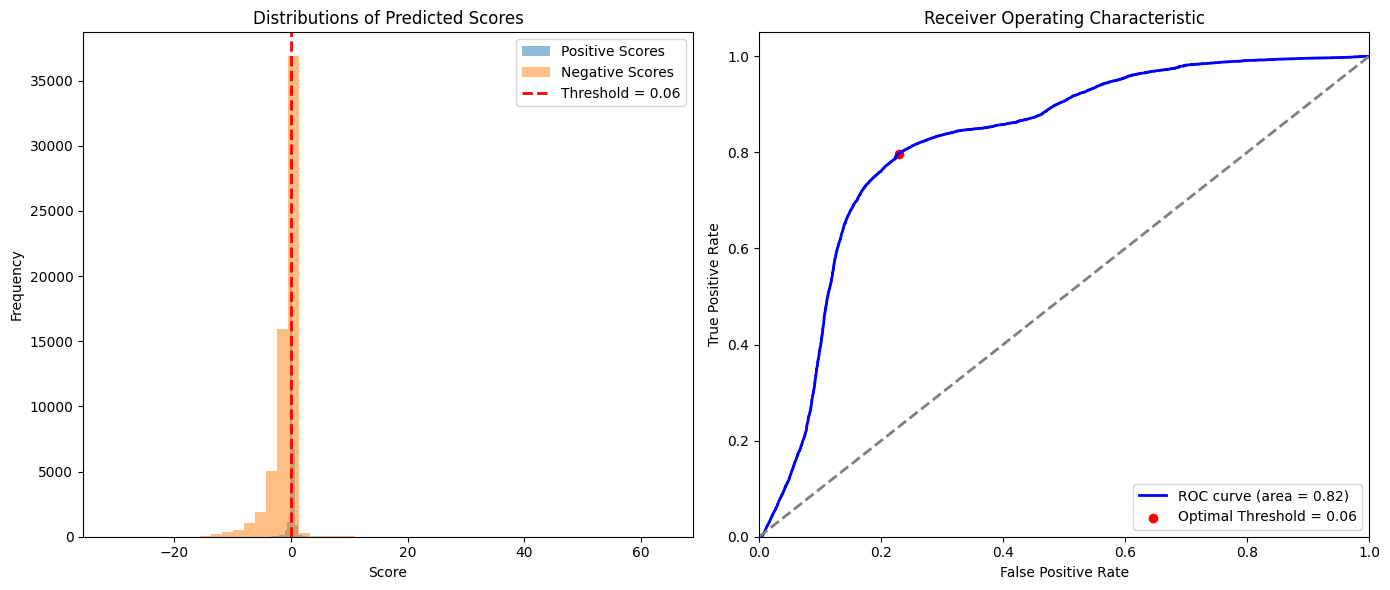

AUC: 0.820466089262625


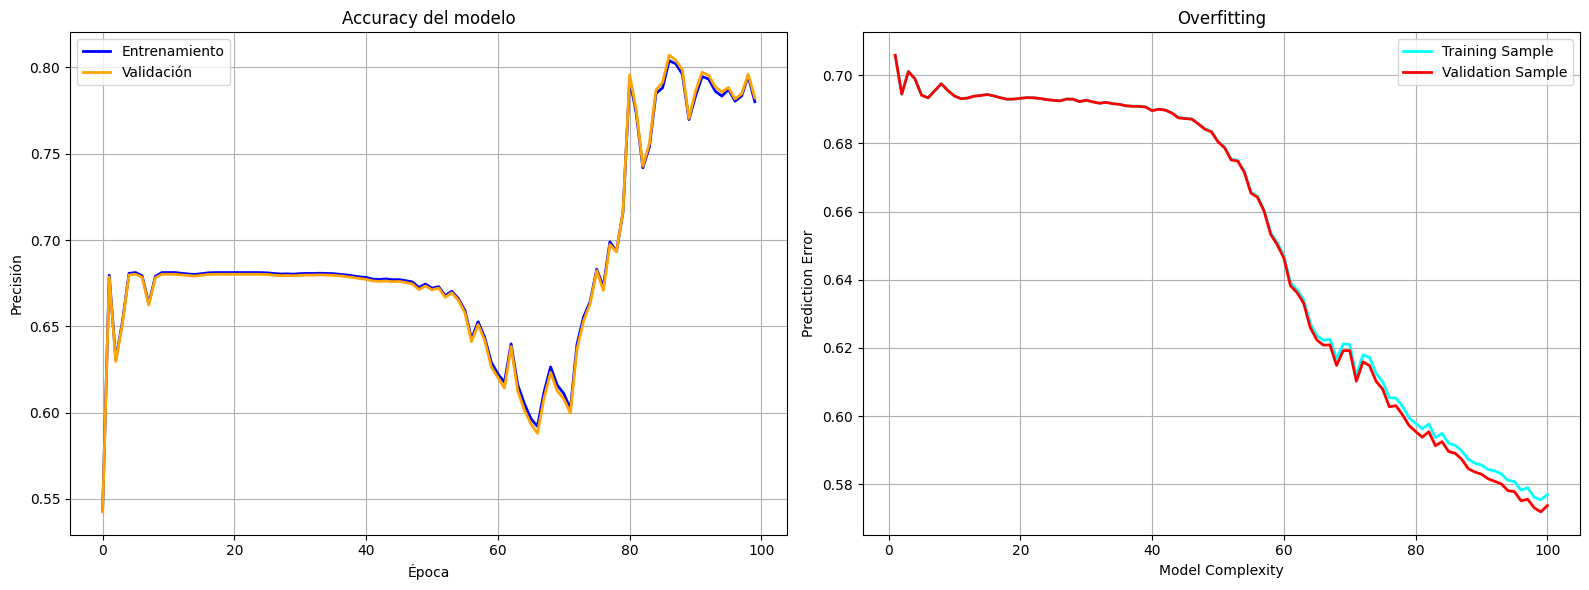

In [30]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask


model = GCN(gnn.dgl_graph.ndata["feat"].size(1),50,1)
# model = ModelGCN(gnn.dgl_graph.ndata["feat"].size(1),16,1)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(epoch + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




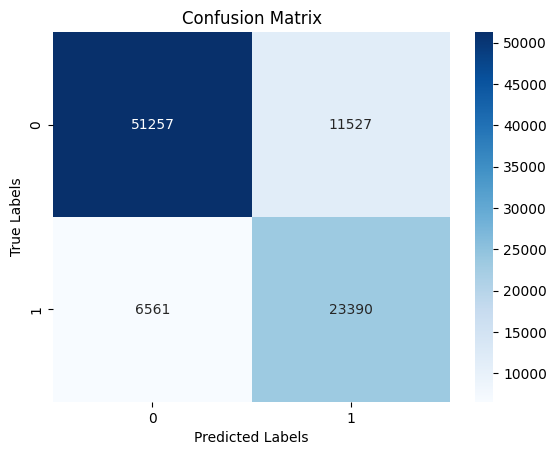

Classification Report:

              precision    recall  f1-score   support

           0     0.8865    0.8164    0.8500     62784
           1     0.6699    0.7809    0.7212     29951

    accuracy                         0.8049     92735
   macro avg     0.7782    0.7987    0.7856     92735
weighted avg     0.8166    0.8049    0.8084     92735



In [29]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

### MLPPredictor

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 276865
Cantidad de False: 185024
Training edges: 276865
Validation edges: 92681
Test edges: 92343
In epoch 0, train loss: 0.7020890712738037, val loss: 0.7019959092140198
In epoch 10, train loss: 0.40365010499954224, val loss: 0.4025517404079437
In epoch 20, train loss: 0.34747514128685, val loss: 0.3453287184238434
In epoch 30, train loss: 0.2928928732872009, val loss: 0.2884787321090698
In epoch 40, train loss: 0.2607352137565613, val loss: 0.25814223289489746
In epoch 50, train loss: 0.236909881234169, val loss: 0.23635713756084442
In epoch 60, train loss: 0.21825021505355835, val loss: 0.21703681349754333
In epoch 70, train loss: 0.20777930319309235, val loss: 0.2069099098443985
In epoch 80, train loss: 0.20973309874534607, val loss: 0.208807170

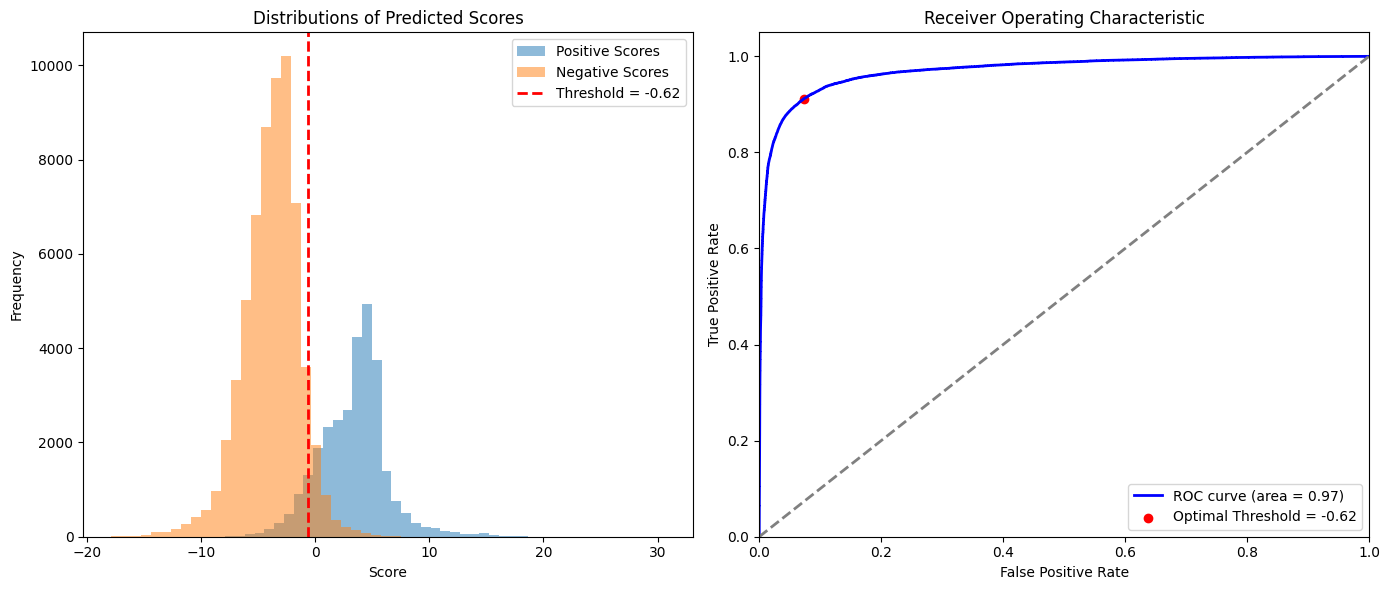

AUC: 0.9705790105302757


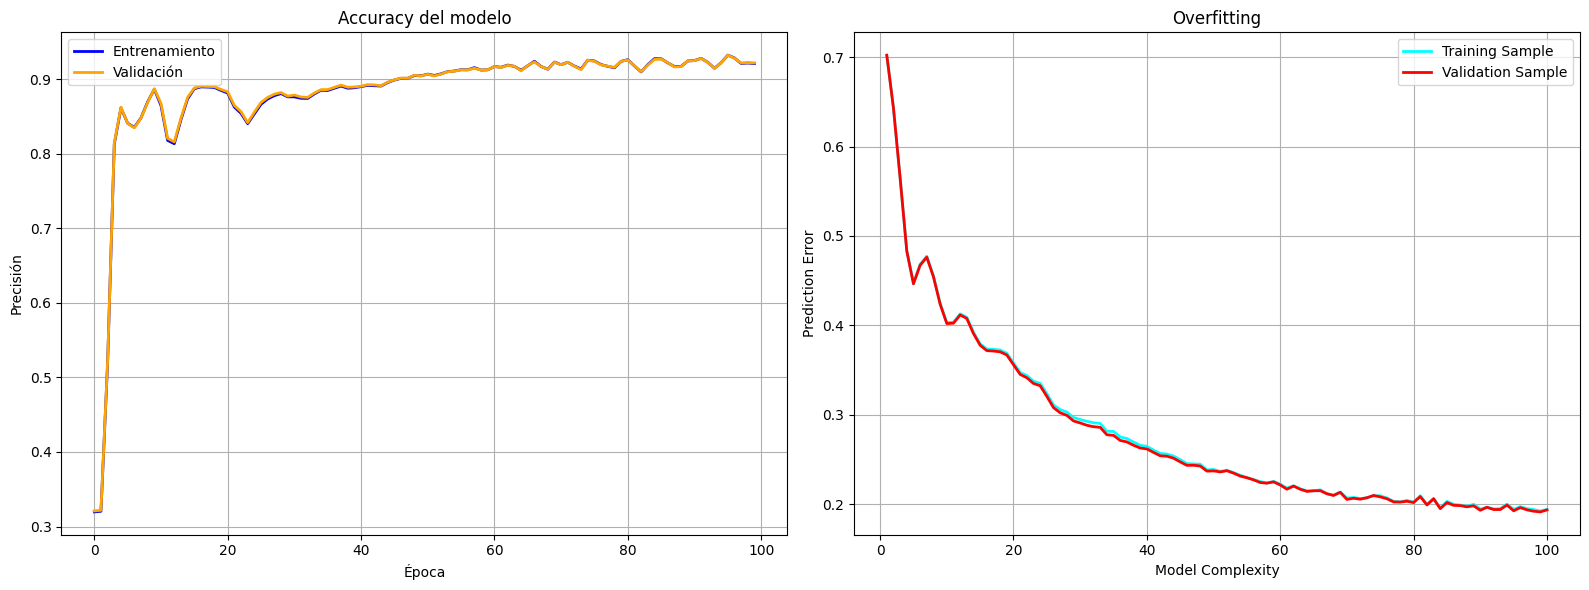

In [21]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask


model = GCN(gnn.dgl_graph.ndata["feat"].size(1),100,50)
# model = ModelGCN(gnn.dgl_graph.ndata["feat"].size(1),16,8)

pred = MLPPredictor(50,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(epoch + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




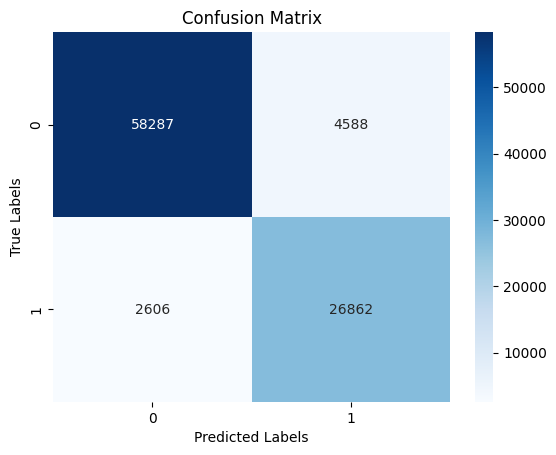

Classification Report:

              precision    recall  f1-score   support

           0     0.9572    0.9270    0.9419     62875
           1     0.8541    0.9116    0.8819     29468

    accuracy                         0.9221     92343
   macro avg     0.9057    0.9193    0.9119     92343
weighted avg     0.9243    0.9221    0.9227     92343



In [22]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

## GraphSAGE

### DotProcductPredictor

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 276871
Cantidad de False: 185018
Training edges: 276871
Validation edges: 92892
Test edges: 92126
In epoch 0, train loss: 1.4971497058868408, val loss: 1.4889024496078491
In epoch 10, train loss: 0.7484262585639954, val loss: 0.7448805570602417
In epoch 20, train loss: 0.6919498443603516, val loss: 0.6920815110206604
In epoch 30, train loss: 0.6543554067611694, val loss: 0.6550738215446472
In epoch 40, train loss: 0.650137186050415, val loss: 0.6490257382392883
In epoch 50, train loss: 0.6343359351158142, val loss: 0.6352360248565674
In epoch 60, train loss: 0.6340306997299194, val loss: 0.6341402530670166
In epoch 70, train loss: 0.625247597694397, val loss: 0.6247411370277405
In epoch 80, train loss: 0.6208977103233337, val loss: 0.622538149356842

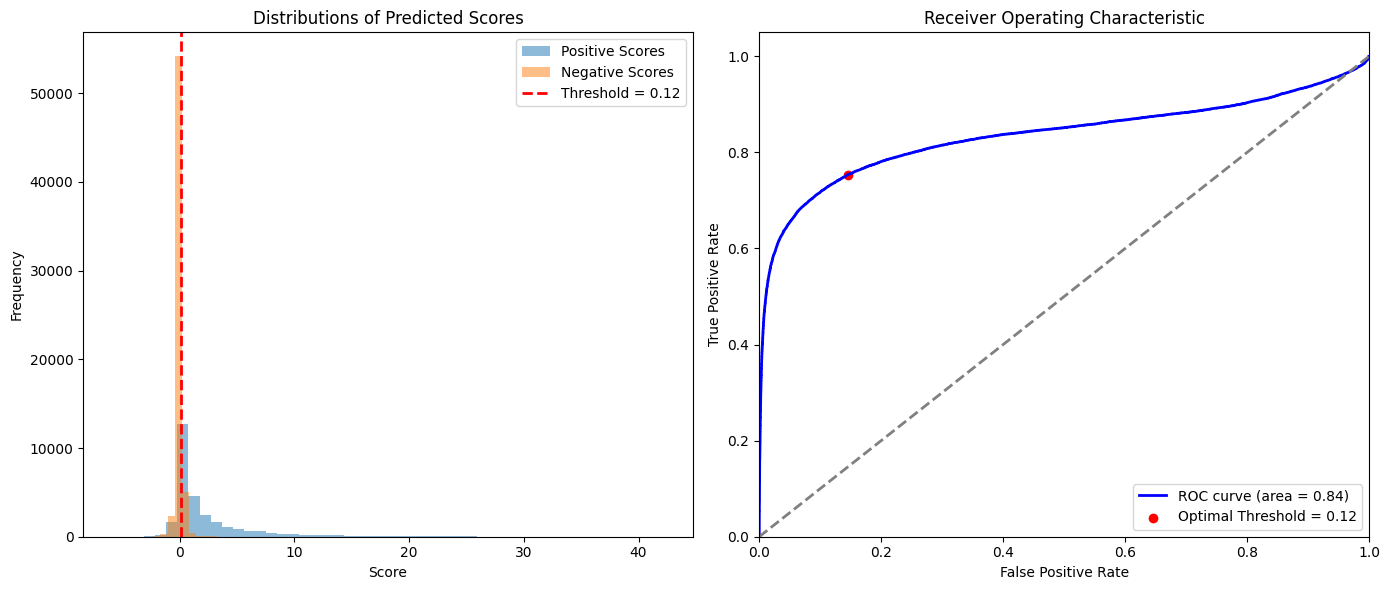

AUC: 0.8351020150725096


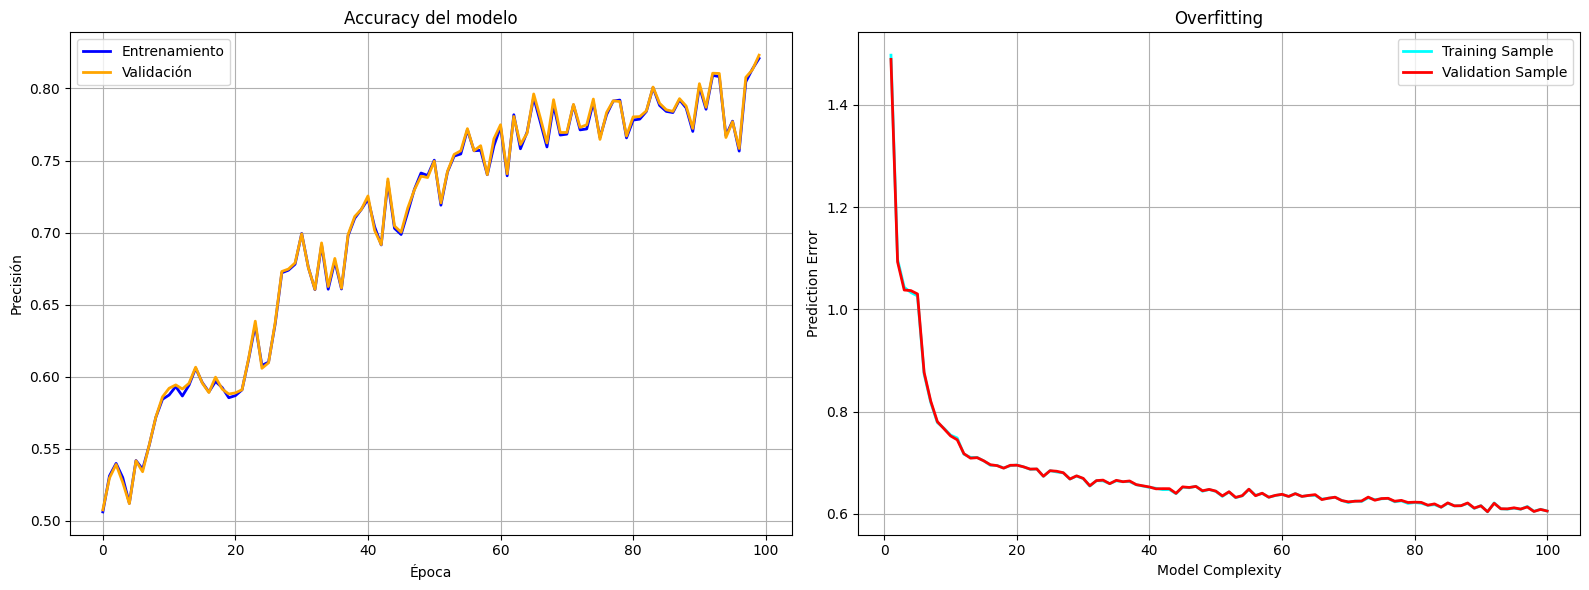

In [11]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
labels = gnn.dgl_graph.edata["Relationship"].float()

model = GraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 15, 1)
# model = ModelGraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 15, 1)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(epoch + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




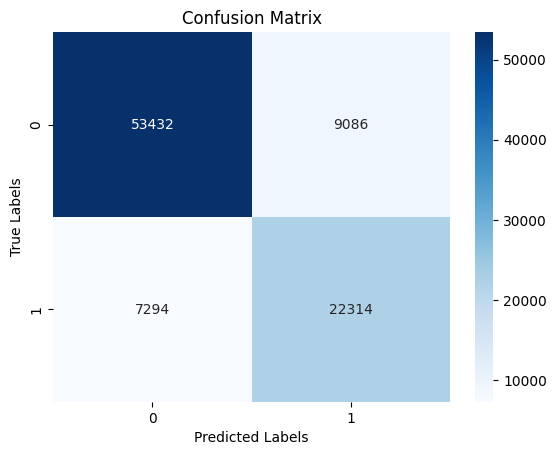

Classification Report:

              precision    recall  f1-score   support

           0     0.8799    0.8547    0.8671     62518
           1     0.7106    0.7536    0.7315     29608

    accuracy                         0.8222     92126
   macro avg     0.7953    0.8042    0.7993     92126
weighted avg     0.8255    0.8222    0.8235     92126



In [12]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

### MLPPredictor

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 277405
Cantidad de False: 184484
Training edges: 277405
Validation edges: 92071
Test edges: 92413
In epoch 0, train loss: 0.7502711415290833, val loss: 0.7496739029884338
In epoch 10, train loss: 0.3694617748260498, val loss: 0.36840683221817017
In epoch 20, train loss: 0.2537687122821808, val loss: 0.2531609535217285
In epoch 30, train loss: 0.17425163090229034, val loss: 0.1747402399778366
In epoch 40, train loss: 0.15540990233421326, val loss: 0.1558602750301361
In epoch 50, train loss: 0.14387449622154236, val loss: 0.14527040719985962
In epoch 60, train loss: 0.13563154637813568, val loss: 0.1362157166004181
In epoch 70, train loss: 0.1312110722064972, val loss: 0.13279694318771362
In epoch 80, train loss: 0.12342260032892227, val loss: 0.12385

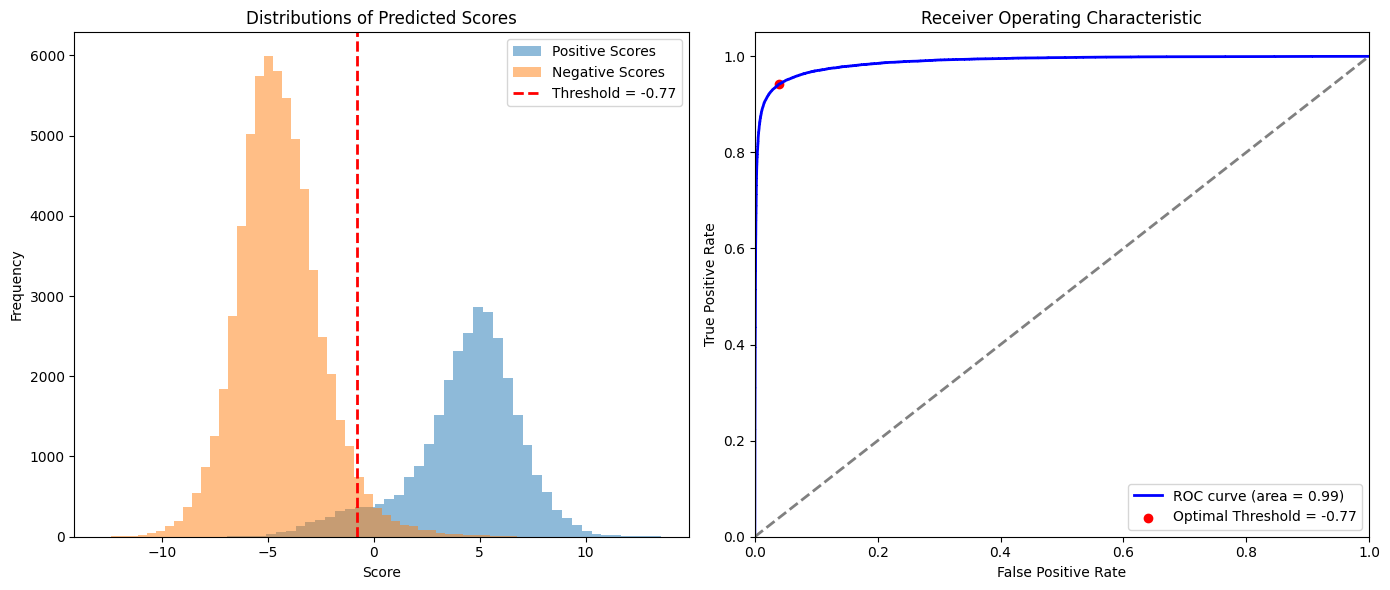

AUC: 0.9881568502651569


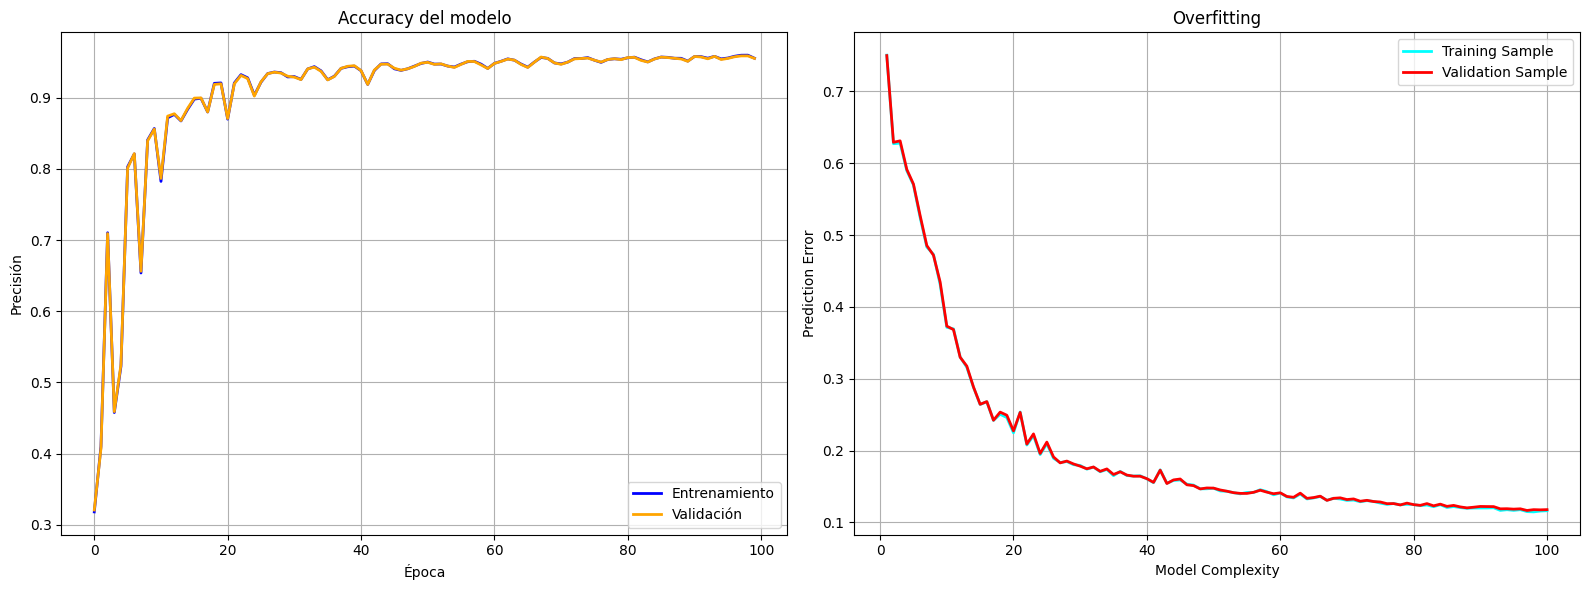

In [19]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask


in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
labels = gnn.dgl_graph.edata["Relationship"].float()

model = GraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 100, 50)
# model = ModelGraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 15, 8)
pred = MLPPredictor(50,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(epoch + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)



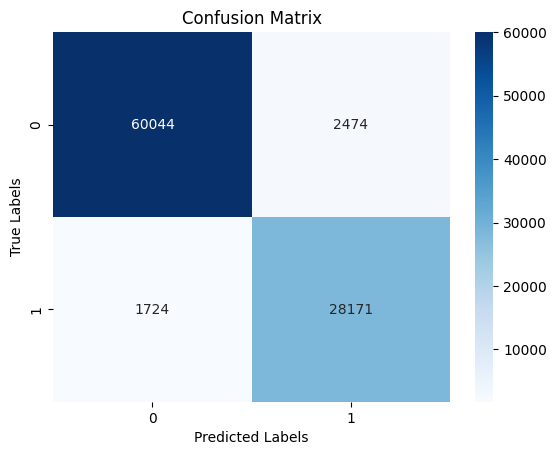

Classification Report:

              precision    recall  f1-score   support

           0     0.9721    0.9604    0.9662     62518
           1     0.9193    0.9423    0.9307     29895

    accuracy                         0.9546     92413
   macro avg     0.9457    0.9514    0.9484     92413
weighted avg     0.9550    0.9546    0.9547     92413



In [20]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor y MLPPredictor
    

In [31]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)


# graph.add_as_rank_api_attributes()
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]


## DotProductPredictor

Done saving data into cached files.
Cantidad de True: 276649
Cantidad de False: 185240
In epoch 0, train loss: 0.8410950899124146, val loss: 0.842183530330658
In epoch 10, train loss: 0.717563807964325, val loss: 0.7190989255905151
In epoch 20, train loss: 0.6918729543685913, val loss: 0.6909889578819275
In epoch 30, train loss: 0.6563615798950195, val loss: 0.657498300075531
In epoch 40, train loss: 0.5646247863769531, val loss: 0.5650389790534973
In epoch 50, train loss: 0.5253298878669739, val loss: 0.5258400440216064
In epoch 60, train loss: 0.49729910492897034, val loss: 0.49824756383895874
In epoch 70, train loss: 0.4925728440284729, val loss: 0.4946989119052887
In epoch 80, train loss: 0.4951190948486328, val loss: 0.49677324295043945
In epoch 90, train loss: 0.48904067277908325, val loss: 0.4905419647693634


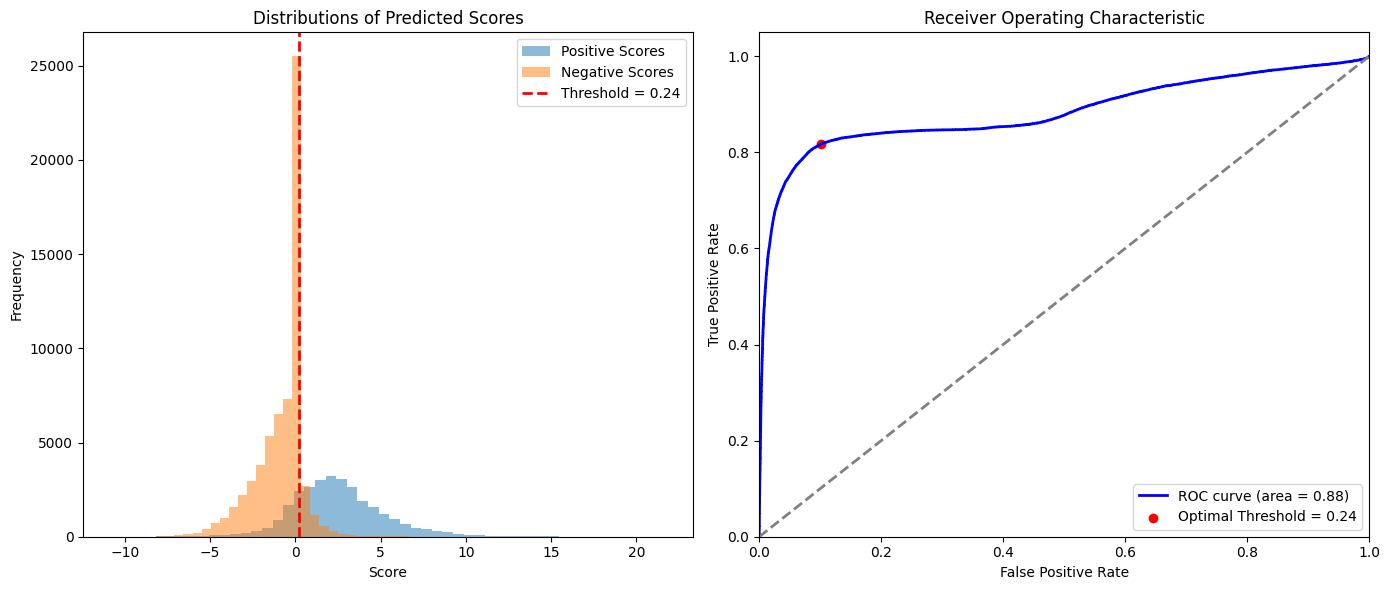

AUC: 0.8833756373506643


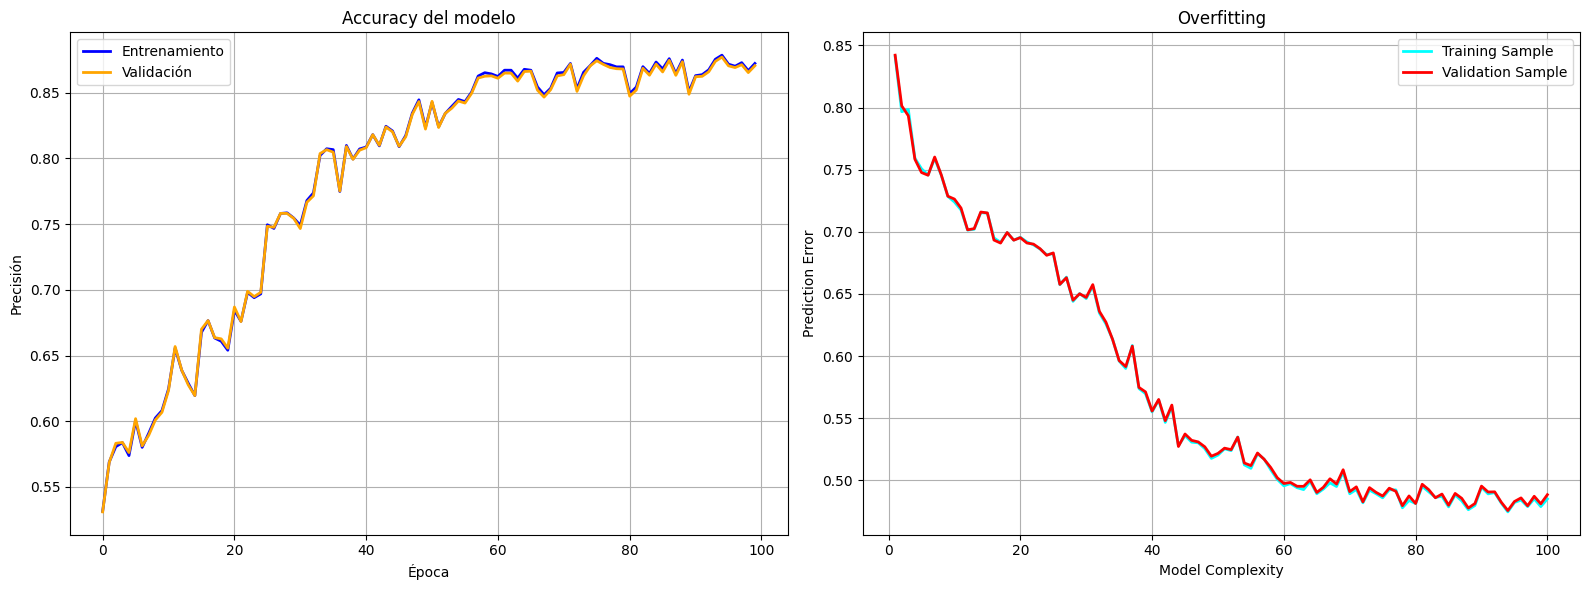

In [32]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 50, 1)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


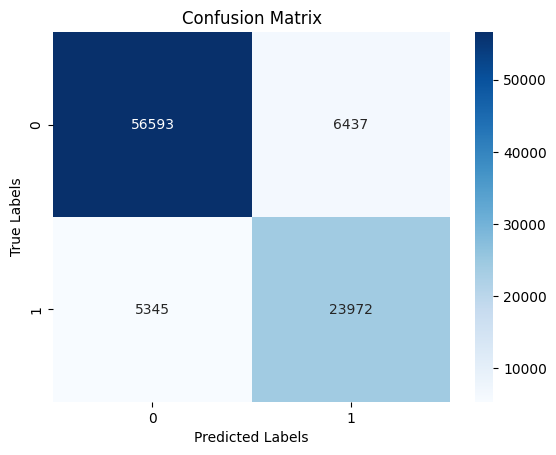

Classification Report:

              precision    recall  f1-score   support

           0     0.9137    0.8979    0.9057     63030
           1     0.7883    0.8177    0.8027     29317

    accuracy                         0.8724     92347
   macro avg     0.8510    0.8578    0.8542     92347
weighted avg     0.8739    0.8724    0.8730     92347



In [33]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

## MLPPreditor

Done saving data into cached files.
Cantidad de True: 277381
Cantidad de False: 184508
In epoch 0, train loss: 0.6753724813461304, val loss: 0.6750221848487854
In epoch 10, train loss: 0.37249916791915894, val loss: 0.3713493347167969
In epoch 20, train loss: 0.28200703859329224, val loss: 0.2824172377586365
In epoch 30, train loss: 0.22712701559066772, val loss: 0.2261033058166504
In epoch 40, train loss: 0.21483100950717926, val loss: 0.211956188082695
In epoch 50, train loss: 0.20053808391094208, val loss: 0.19887375831604004
In epoch 60, train loss: 0.1896890252828598, val loss: 0.18818511068820953
In epoch 70, train loss: 0.1863694041967392, val loss: 0.1845621019601822
In epoch 80, train loss: 0.18533305823802948, val loss: 0.1840304434299469
In epoch 90, train loss: 0.1847153902053833, val loss: 0.18212781846523285


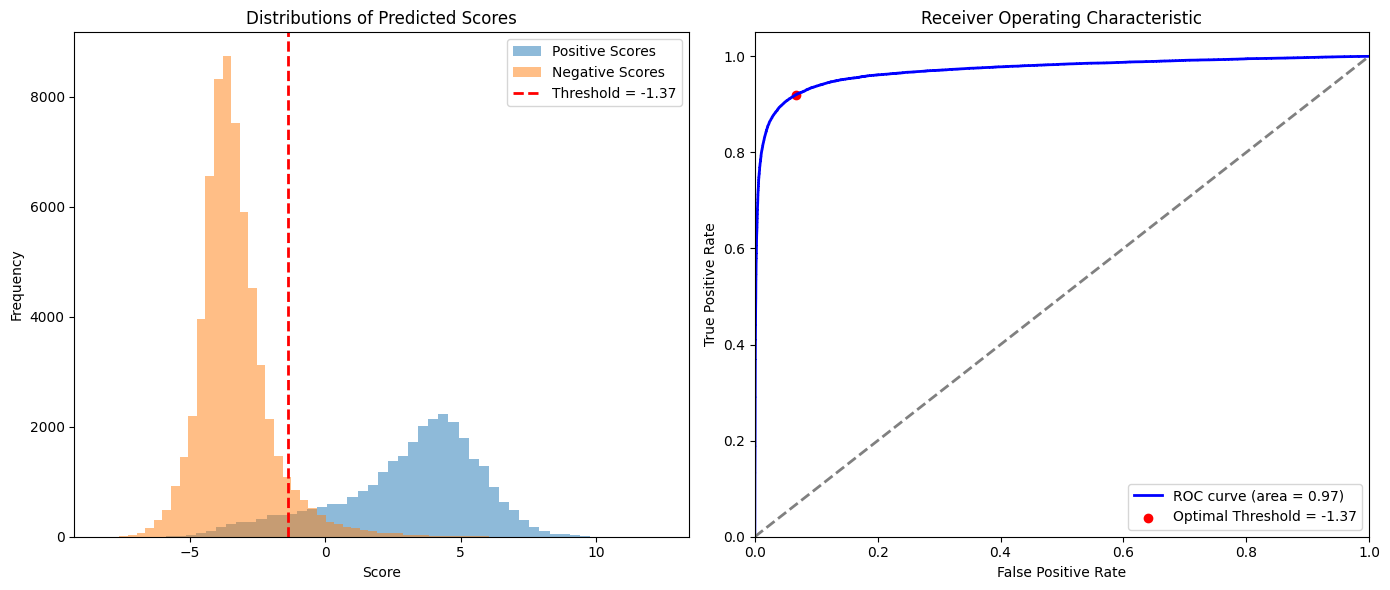

AUC: 0.9712306182360285


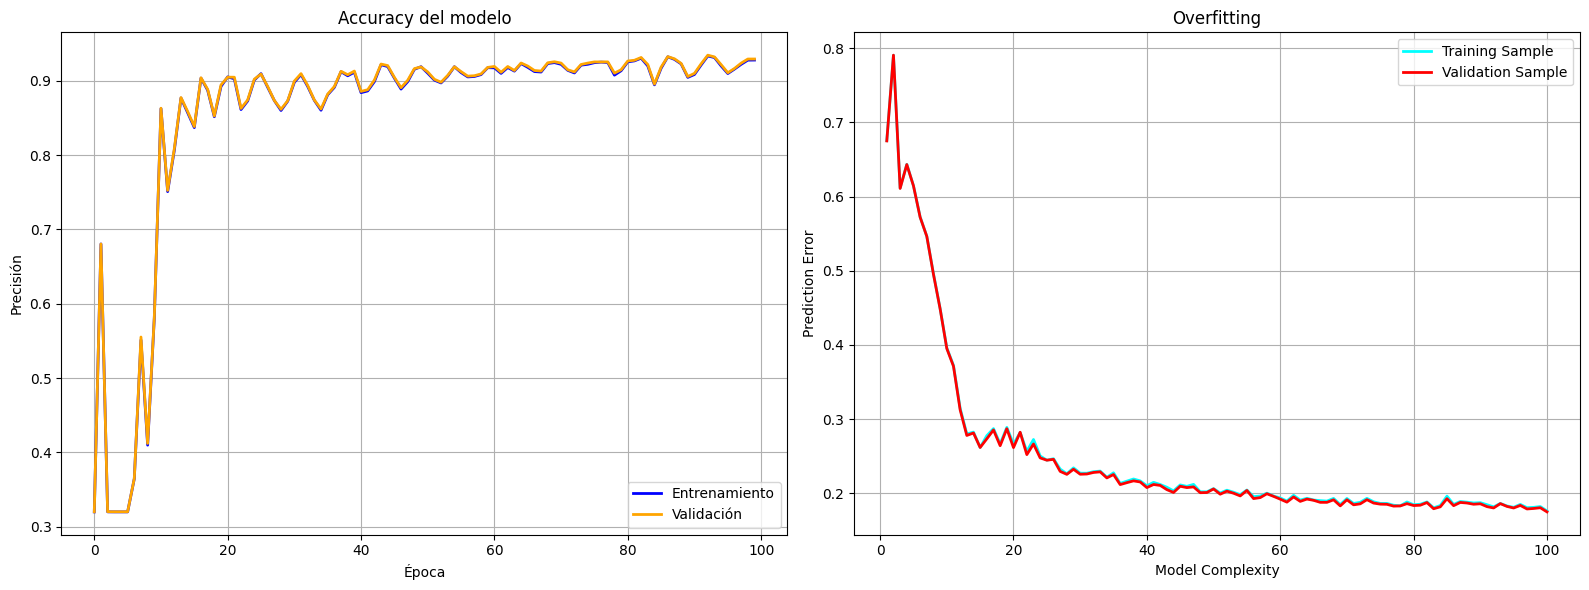

In [35]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(gnn.dgl_graph.ndata["feat"].size(1), 100, 50)
pred = MLPPredictor(50,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


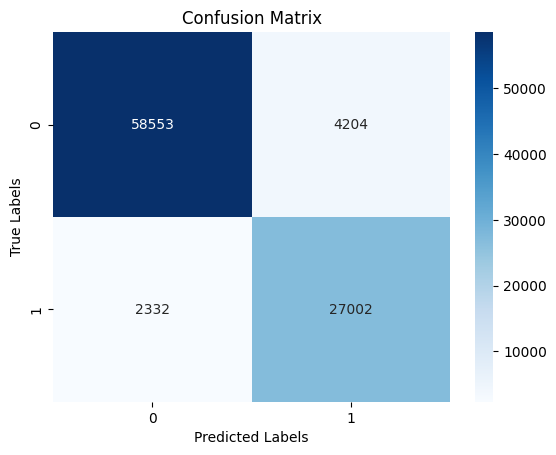

Classification Report:

              precision    recall  f1-score   support

           0     0.9617    0.9330    0.9471     62757
           1     0.8653    0.9205    0.8920     29334

    accuracy                         0.9290     92091
   macro avg     0.9135    0.9268    0.9196     92091
weighted avg     0.9310    0.9290    0.9296     92091



In [36]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [38]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

LIST_FEATURES_NO_CATEG = [
                        # 'AS_rank_numberAsns', 
                        # 'AS_rank_customer', 
                        'peeringDB_fac_count', 
                        'cti_top']

LIST_FEATURES_CATEG = [
                        # 'AS_rank_continent',
                        #  'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        # 'ASDB_C1L1'
                        ]

# Crear Di graph 
# list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
# list_feat =  LIST_FEATURES_NO_CATEG
list_feat = ['AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']


path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)


# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
Cantidad de True: 277530
Cantidad de False: 184359
[IN_FEATS] torch.Size([74145, 6])
[DGL Graph] Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})
In epoch 0, train loss: 0.6573945879936218, val loss: 0.6580353379249573
In epoch 10, train loss: 0.2584465742111206, val loss: 0.2599623501300812
In epoch 20, train loss: 0.2329399287700653, val loss: 0.2354259192943573
In epoch 30, train loss: 0.18652622401714325, val loss: 0.18781132996082306
In epoch 40, train loss: 0.16676568984985352, val loss: 0.16724658012390137
In epoch 50, train loss: 0.1622849851846695, val loss: 0.16291722655296326
In epoch 60, train loss: 0.1499803513288498, val loss: 0.1517433226108551
In epoch 70,

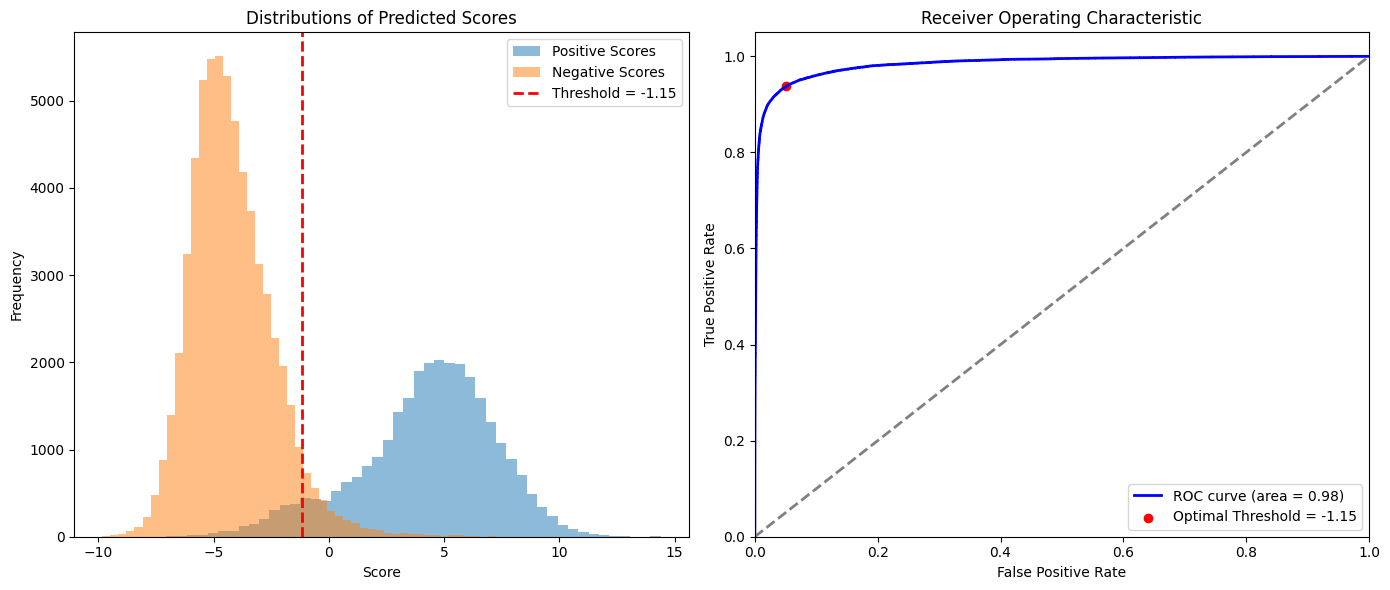

AUC: 0.9843964979891069


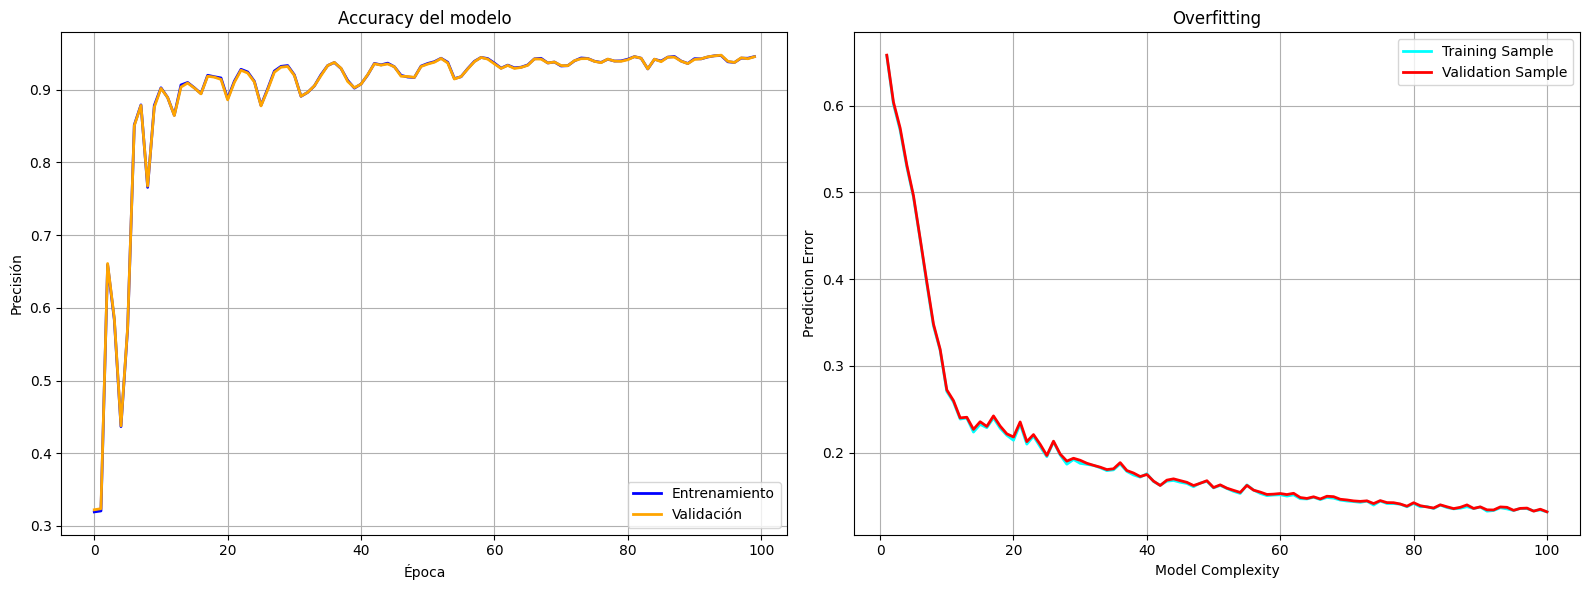

In [40]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"]
print("[IN_FEATS]",in_feats.shape)


# DATASET GRAPH ----------------------------------------------
print("[DGL Graph]",gnn.dgl_graph)

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(gnn.dgl_graph.ndata["feat"].size(1) , 100, 50)
pred = MLPPredictor(50,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.005)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


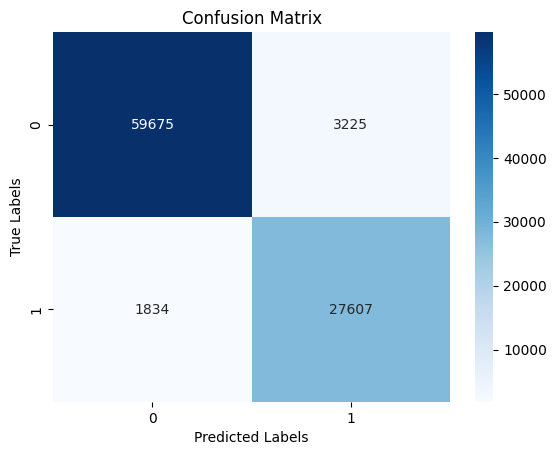

Classification Report:

              precision    recall  f1-score   support

           0     0.9702    0.9487    0.9593     62900
           1     0.8954    0.9377    0.9161     29441

    accuracy                         0.9452     92341
   macro avg     0.9328    0.9432    0.9377     92341
weighted avg     0.9463    0.9452    0.9455     92341



In [41]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
features_filename 

In [8]:
# Creación archivos edges.csv y nodes.csv para cada archivo de rrc y caida ----------------------------
# para la creación de nuestro dataset
path_files_rrc = "datasets/ROUTE_COLLECTORS/Downloads/"
path_files_caida = "datasets/CAIDA_AS_Relationships/Serial_2/"
list_downloaded_rrc_files = os.listdir(path_files_rrc)
list_caida_As_relationship = os.listdir(path_files_caida)
print(list_downloaded_rrc_files)
# list_downloaded_rrc_files = ['graph-2021-06-rrc03-ribs-edges.csv']
# list_downloaded_rrc_files = [ 'graph-2021-06-rrc03-ribs-edges.csv','graph-2022-03-rrc03-ribs-edges.csv','graph-2022-04-rrc01-ribs-edges.csv']

for edgelist_files in list_downloaded_rrc_files:

    # Extraer rrc, fecha y obtener archivo caida p ara año y mes    
    rrc = edgelist_files.split("-")[3]
    date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
    finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
    filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
    filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

    edge_list_source_file_csv = path_files_rrc + edgelist_files
    labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
    # labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2" #FIXME:Aqui esta el error
    
    # Directorio DGL Graph
    directory = f"datasets/DGL_Graph/Graphs{rrc}/"

    # Crear el directorio si no existe
    if not os.path.exists(directory):
        os.makedirs(directory)

    graph = Graph(f"datasets/DGL_Graph/Graphs{rrc}/", debug=True)
    graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph",filename_out=filename_edges)
    print("[TOPOLOGÍA]", graph.nx_graph)
    # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
    features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
    # graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)
    graph.only_degree_features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

    # 3.- Eliminar nodos de grado 1 hojas
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    print("-------------------------------")


['graph-2022-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc23-ribs-edges.csv', 'graph-2021-01-rrc01-ribs-edges.csv', 'graph-2020-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc15-ribs-edges.csv', 'graph-2022-01-rrc01-ribs-edges.csv', 'graph-2022-01-rrc23-ribs-edges.csv', 'graph-2020-01-rrc01-ribs-edges.csv']
[Tamaño df_edges: (470202, 3)]
[Tamaño df_edges_labeless: (204856, 2)]
Creando archivo edges.csv
[Tamaño Data Frame Merge]: (204856, 3)
[Grafo NX]: DiGraph with 78692 nodes and 204854 edges
[SAVE IN]: datasets/DGL_Graph/Graphsrrc15/edges_rrc15.csv
[TOPOLOGÍA] DiGraph with 78692 nodes and 204854 edges


TypeError: Graph.only_degree_features_nodes() got an unexpected keyword argument 'list_feat'

In [7]:
# Extraer rrc, fecha y obtener archivo caida p ara año y mes   
edgelist_files = 'graph-2022-01-rrc15-ribs-edges.csv'
rrc = edgelist_files.split("-")[3]
date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

edge_list_source_file_csv = path_files_rrc + edgelist_files
labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"

graph = Graph(f"datasets/DGL_Graph/GraphsRRC{rrc}/", debug=True)
graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph")
print("[TOPOLOGÍA]", graph.nx_graph)
# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

# 3.- Eliminar nodos de grado 1 hojas
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

NameError: name 'list_caida_As_relationship' is not defined

In [6]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/Graphsrrc01"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)

print(gnn.dgl_graph)

gnn.split_dataset_edges(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




Done saving data into cached files.
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Training edges: 95583
Validation edges: 31899
Test edges: 31485
In epoch 0, train loss: nan, val loss: nan
In epoch 10, train loss: nan, val loss: nan
In epoch 20, train loss: nan, val loss: nan
In epoch 30, train loss: nan, val loss: nan
In epoch 40, train loss: nan, val loss: nan
In epoch 50, train loss: nan, val loss: nan
In epoch 60, train loss: nan, val loss: nan
In epoch 70, train loss: nan, val loss: nan
In epoch 80, train loss: nan, val loss: nan
In epoch 90, train loss: nan, val loss: nan


/home/vale/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [ ]:
# TODO: Importar segundo dataset para el test

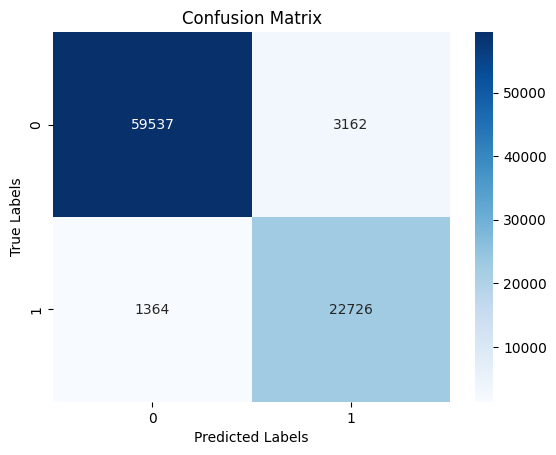

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9496    0.9634     62699
           1     0.8779    0.9434    0.9094     24090

    accuracy                         0.9479     86789
   macro avg     0.9277    0.9465    0.9364     86789
weighted avg     0.9499    0.9479    0.9484     86789



In [55]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 6:
    * Model : ???
    * Features : ???
    * Predictor : ???
Agrefo mis atributos sacados de APIs

In [ ]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

In [3]:
date = "2020-01-01"
graph_api = Graph_API(path="datasets/DGL_Graph/Graphsrrc01/", date=date,debug=True)
edge_list_source_file_csv = "datasets/ROUTE_COLLECTORS/Downloads/graph-2020-01-rrc01-ribs-edges.csv"
# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
# graph_api.label_edgelist(edge_list_source_file_csv, type="DiGraph", filename_out="edges_rrc01.csv") #Se de mora demaiado tiempo

graph_api.read_from_relationship_edgelist(file_path,type,out_file="edges_rrc01.csv")
print("[TOPOLOGÍA]", graph_api.nx_graph)

# asn = "14117"  # Reemplaza este valor con el ASN que desees consultar
result = graph_api.features_nodes(filename_out="nodes_rrc01.csv")
# Filtrar edges con nodos 
graph_api.filter_edges_with_attributes(nodes_file="nodes_rrc01.csv", edges_file="edges_rrc01.csv", output_file="edges_rrc01.csv")

# graph_api.normalize_features("nodes_rrc01.csv","nodes_rrc01.csv")

# print(result)  # Imprimir el JSON retornado

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
Creating nodes.csv file
[PATH] datasets/DGL_Graph/Graphsrrc01/nodes_rrc01.csv
Node 500 of 74145 processed
Node 1000 of 74145 processed
Node 1500 of 74145 processed
Node 2000 of 74145 processed
Node 2500 of 74145 processed
Node 3000 of 74145 processed
Node 3500 of 74145 processed
Node 4000 of 74145 processed
Node 4500 of 74145 processed
Node 5000 of 74145 processed
Node 5500 of 74145 processed
Node 6000 of 74145 processed
Node 6500 of 74145 processed
Node 7000 of 74145 processed
Node 7500 of 74145 processed
Node 8000 of 74145 processed
Node 8500 of 74145 processed
Node 9000 of 74145 processed
Node 9500 of 74145 processed
Node 10000 of 74145 processed
Node 10500 of 74145 processed
Node 11000 of 74145 processed
Node 11500 of 74145 processed
Node 12000 of 74145 processed
Node 12500 of 74145 processed
Node 13000 of 74145 processed
Node 13500 of 74145 processed
Node 14000 of 74145 processed
Node 14500 of 74145 processed
Node 15000 of 7414

TypeError: 'NoneType' object is not subscriptable

# Caso 7:
    * Model : GraphSAGE 
    * Features : ???
    * Predictor : MLP

SAMPLING-> Neighbour node sampling
BATCH NORMALIZATION -> no
DROPOUT -> shi



In [45]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# NO PERMITE TENER NODOS CON GRADO 0
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


In [46]:
# Grafo
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)
gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
node_features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.edata["Relationship"].float()

# gnn.split_dtaset_v2()
train_mask = gnn.train_mask
test_mask = gnn.test_mask

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")

Done saving data into cached files.
Cantidad de True: 276957
Cantidad de False: 184932
TRAIN IDX: tensor([ True, False,  True,  ...,  True,  True,  True])
TEST IDX: tensor([False,  True, False,  ..., False, False, False])
TRAIN NIDS: tensor([     0,      2,      4,  ..., 461886, 461887, 461888])
TEST NIDS: tensor([     1,      3,      7,  ..., 461859, 461866, 461870])


In [61]:
# Definir Dataloader y Sampler Training
sampler = dgl.dataloading.NeighborSampler([2, 2])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([2,2])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



  0%|          | 0/277 [00:00<?, ?it/s]/home/vale/.local/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 93/93 [00:00<00:00, 247.20it/s]


In epoch 0, train loss: 0.3139401972293854,


100%|██████████| 93/93 [00:00<00:00, 227.17it/s]


In epoch 1, train loss: 0.3214993178844452,


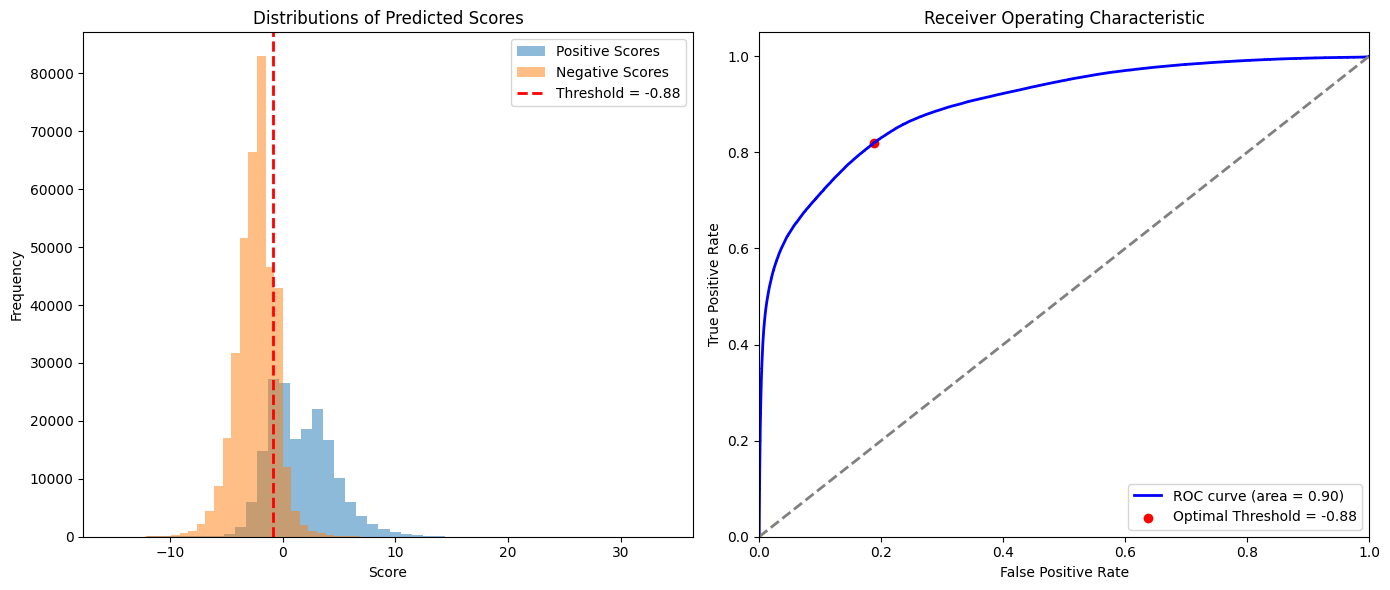

AUC: 0.9003714838425196
Optimal Threshold: -0.8845597505569458
Train Error [0.6798199415206909, 2.956730842590332, 0.6744698882102966, 0.6287575960159302, 0.8565875291824341, 1.0515124797821045, 0.7777712941169739, 0.6022395491600037, 0.6376481652259827, 0.6551997661590576, 0.6704541444778442, 0.6703144907951355, 0.6583345532417297, 0.6441373229026794, 0.6343868374824524, 0.6381001472473145, 0.6375734210014343, 0.6354256272315979, 0.614085853099823, 0.5950818657875061, 0.6030190587043762, 0.5790725350379944, 0.5755380392074585, 0.5331125855445862, 0.5627508759498596, 0.5841253995895386, 0.5701689720153809, 0.5639447569847107, 0.5274115800857544, 0.548901379108429, 0.5649518370628357, 0.5382769703865051, 0.5656339526176453, 0.5262230634689331, 0.4860062897205353, 0.4806930422782898, 0.4737006425857544, 0.5135183334350586, 0.506122887134552, 0.5320970416069031, 0.5122780799865723, 0.4750976860523224, 0.42292943596839905, 0.43730488419532776, 0.4103725552558899, 0.4265228807926178, 0.4206

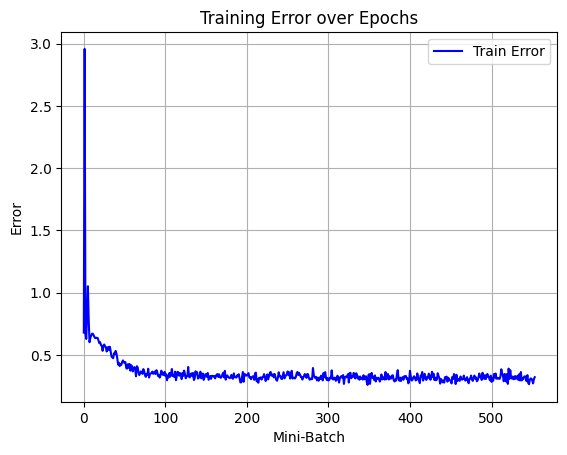

In [79]:

# # model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = ModelSAGESample(gnn.dgl_graph.ndata["feat"].size(1), 50, 25)
pred = MLPPredictor(25,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #
acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error_per_epoch = []
train_edges_id = []

# Inicializar listas para guardar logits y labels del entrenamiento
all_logits_train = []
all_labels_train = []

# Inicializar listas para guardar logits y labels de la validacion
all_logits_val = []
all_labels_val = []
# Almacenar la importancia de características por epoch
feature_importances = []
for epoch in range(2):
    model.train()
    val_loss_epoch=0
    num_batches = 0

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
    
            mfgs = [graph for graph in mfgs]
            edge_ids = output_graph.edata[dgl.EID]
            inputs = mfgs[0].srcdata['feat']
            # Hacer que los inputs requieran gradiente
            inputs.requires_grad_(True)
            # Embeddings de nodos
            h = model(mfgs, inputs)
            logits =  pred(output_graph, h)
            
            
            train_edges_id.append(edge_ids)

            # Usar los IDs de los bordes para obtener las etiquetas reales
            labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].float()

            all_logits_train.append(logits.detach().cpu().numpy())
            all_labels_train.append(labels_batch_output.cpu().numpy())
            # print("LOGITS",logits,logits.shape)
            # print("LABEL",mfgs[-1].edata['Relationship'].shape )

            # Calculo pérdida --------------------------------------------------------
            train_loss = F.binary_cross_entropy_with_logits(logits, labels_batch_output)
            train_error.append(train_loss.item())


            val_loss_epoch += train_loss.item()
            num_batches += 1
            
            # backward
            optimizer.zero_grad()
            # train_loss.backward()
            train_loss.backward()

                        # Capturar los gradientes con respecto a los inputs (características)
            grad = inputs.grad  # Este es el gradiente de la pérdida con respecto a los inputs
            feature_importance_batch = grad.abs().mean(dim=0).cpu().numpy()  # Promediar sobre los nodos y las dimensiones de características
            feature_importances.append(feature_importance_batch)
            optimizer.step()

    train_error_per_epoch.append(val_loss_epoch / num_batches)
        
    # Validación
    model.eval()
    val_loss_epoch = 0
    num_batches = 0
    with torch.no_grad():
        with tqdm.tqdm(test_dataloader) as tq:
            for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
                mfgs = [graph for graph in mfgs]
                edge_ids = output_graph.edata[dgl.EID]
                inputs = mfgs[0].srcdata['feat']
                
                
                # Forward para validación
                h_val = model(mfgs, inputs)
                logits_val = pred(output_graph, h_val)

                # Guardar logits de validacion
                all_logits_val.append(logits_val.detach().cpu().numpy())

                # Obtener las etiuetas reales
                labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].float()
                all_labels_val.append(labels_batch_output_val.cpu().numpy())
            
                # Calcular pérdida de validación
                val_loss_batch = F.binary_cross_entropy_with_logits(logits_val, labels_batch_output_val)
                val_loss_epoch += val_loss_batch.item()
                num_batches += 1

    # Almacenar el promedio de la pérdida de validación por epoch
    val_error_per_epoch.append(val_loss_epoch / num_batches)


    if epoch % 1 == 0:
        print('In epoch {}, train loss: {},'.format( epoch,train_loss))



# ----------- 5. Definir threashold -------------- 
# Concatenar todos los logits y etiquetas al final del entrenamiento
all_logits_train = np.concatenate(all_logits_train, axis=0)
all_labels_train = np.concatenate(all_labels_train, axis=0)
optimal_threshold = plot_roc_curve(all_labels_train, all_logits_train)
print(f"Optimal Threshold: {optimal_threshold}")
          

# ----------- 6. plot the loss and accuracy de training-------------- #
# FIXME: Ess asi por meintras para q no s ecaiga la funcion
print("Train Error",train_error)
# acc_train = train_error
# val_error = train_error
# acc_val = train_error
# model_complexity = [i for i in range(len(train_error))]


# Crear gráfico del error de entrenamiento
plt.figure()  # Crear una nueva figura
plt.plot([i for i in range(len(train_error))],train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.xlabel('Mini-Batch')
plt.ylabel('Error')
plt.title('Training Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico de error de entrenamiento


# ----------- 6. Visualización de la Importancia de Características -------------- #
# Convertir la lista de importancias en un array para análisis
# feature_importances = np.array(feature_importances)

# Calcular la importancia promedio a lo largo de todos los batches y epochs
# avg_feature_importance = feature_importances.mean(axis=0)

# plt.figure()
# plt.bar(range(len(avg_feature_importance)), avg_feature_importance)
# plt.xlabel('Feature Index')
# plt.ylabel('Average Importance')
# plt.title('Average Feature Importance over Training')
# plt.show()


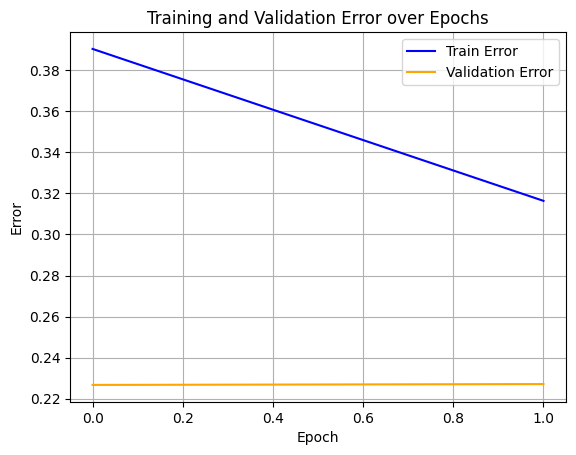

In [80]:
# Crear gráfico combinado de error de entrenamiento y validación
plt.figure()  # Crear una nueva figura
plt.plot(train_error_per_epoch, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.plot(val_error_per_epoch, label='Validation Error', color='orange')  # Error de validación en naranja
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico combinado

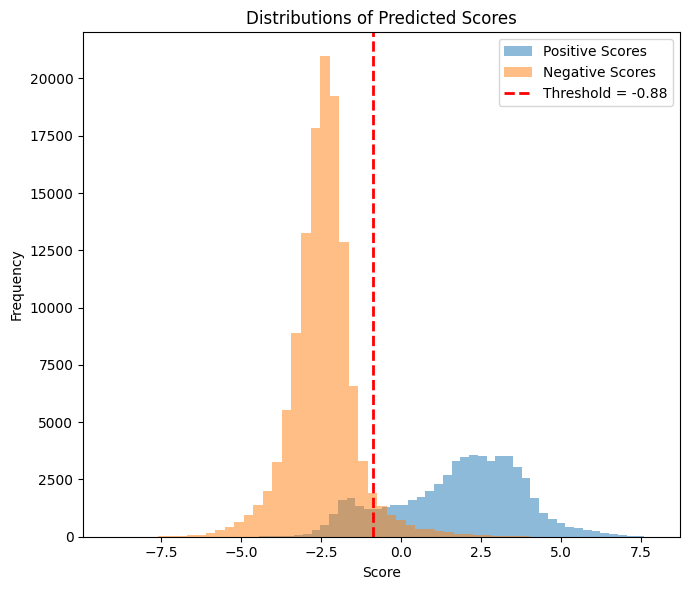

AUC: 0.966759551443531


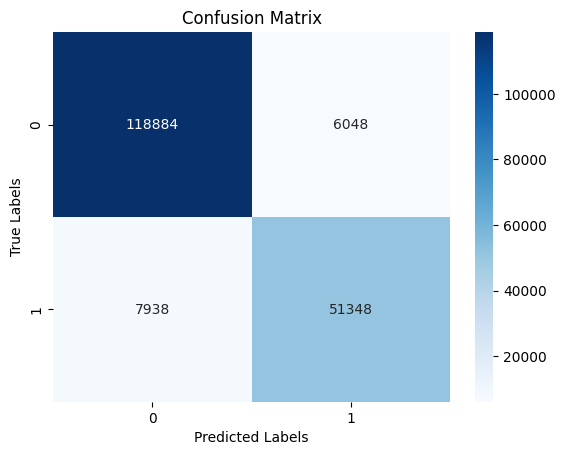

Classification Report:

              precision    recall  f1-score   support

         0.0     0.9374    0.9516    0.9444    124932
         1.0     0.8946    0.8661    0.8801     59286

    accuracy                         0.9241    184218
   macro avg     0.9160    0.9088    0.9123    184218
weighted avg     0.9236    0.9241    0.9237    184218



In [81]:
all_logits_val = np.concatenate(all_logits_val, axis=0)
all_labels_val = np.concatenate(all_labels_val, axis=0)

plot_roc_curve(all_labels_val, all_logits_val, optimal_threshold)
calculate_metrics(all_logits_val,all_labels_val , optimal_threshold)


In [82]:
# Concatenar todos los logits y etiquetas de validación
all_logits_val = np.concatenate(all_logits_val, axis=0)
all_labels_val = np.concatenate(all_labels_val, axis=0)

# # Usar sigmoid para convertir los logits en probabilidades
# probs_val = torch.sigmoid(torch.tensor(val_logits))

# Definir el umbral óptimo o usar un valor por defecto (0.5)
threshold = optimal_threshold
all_logits_val = (all_logits_val > threshold).astype(float)  #.numpy()
# print(preds_val)
print(all_logits_val)
print(all_labels_val)
# Generar el classification report para la validación
report_val = classification_report(all_logits_val, all_logits_val, target_names=['Class 0', 'Class 1'])

# Mostrar el classification report de validación
print(report_val)
            

ValueError: zero-dimensional arrays cannot be concatenated

# Caso 8:
    * Model : GraphSAGE 
    * Features : ???
    * Predictor : MLP

SAMPLING-> cluster
BATCH NORMALIZATION -> no
DROPOUT -> shi


In [83]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_nodes()

Done saving data into cached files.


In [84]:
# Grafo
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)

gnn.split_dataset_edges(0.5)
gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:


Done saving data into cached files.
Cantidad de True: 230503
Cantidad de False: 231386


In [85]:
num_parts = 1000
g = gnn.dgl_graph
sampler = dgl.dataloading.ClusterGCNSampler(g, num_parts)
dataloader = dgl.dataloading.DataLoader(
    g, 
    torch.arange(num_parts), 
    sampler,
    batch_size=20, 
    shuffle=True, 
    drop_last=False, 
    num_workers=4
)

# for subg in dataloader:
#     print(subg)
#     print("-------------------------------")

Convert a graph into a bidirected graph: 0.016 seconds, peak memory: 13.656 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 13.656 GB
Metis partitioning: 0.686 seconds, peak memory: 13.656 GB


[19:19:57] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 74145 nodes and 923778 edges into 1000 parts and get 386219 edge cuts


In [86]:
model = GraphSAGE(gnn.dgl_graph.ndata["feat"].shape[1], 100, 25)
pred = MLPPredictor(25,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #
acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error_per_epoch = []
train_edges_id = []

# Inicializar listas para guardar logits y labels del entrenamiento
all_logits_train = []
all_labels_train = []

# Inicializar listas para guardar logits y labels de la validacion
all_logits_val = []
all_labels_val = []
for epoch in range(5):
    # model.train()
    for it, sg in enumerate(dataloader):
        # print(it,sg)
        inputs = sg.ndata['feat'].float()
        # print("[INPUTS]",inputs)
        labels = sg.edata['Relationship'].float()

        train_mask = sg.edata['train_mask'].bool()
        # print("[TRAIN_MASK]",train_mask)

        h = model(sg, inputs)
        logits =  pred(sg, h)

        # print("[LABELS]",labels)
        all_logits_train.append(logits[train_mask].detach().cpu().numpy())
        all_labels_train.append(labels[train_mask].cpu().numpy())
        
        # logits = model(sg, inputs)
        train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
        train_error.append(train_loss.item())
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if epoch % 5000 == 0:
        #     print(f"Loss {train_loss}")

        


    model.eval()
    with torch.no_grad():
        val_preds, test_preds = [], []
        val_labels, test_labels = [], []
        for it, sg in enumerate(dataloader):
            inputs = sg.ndata["feat"]
            labels = sg.edata["Relationship"]

            val_mask = sg.edata["val_mask"].bool()
            test_mask = sg.edata["test_mask"].bool()

            h = model(sg, inputs)
            logits =  pred(sg, h)

            val_preds.append(logits[val_mask])
            val_labels.append(labels[val_mask])
            test_preds.append(logits[test_mask])
            test_labels.append(labels[test_mask])

        val_preds = torch.cat(val_preds, 0)
        val_labels = torch.cat(val_labels, 0)
        test_preds = torch.cat(test_preds, 0)
        test_labels = torch.cat(test_labels, 0)




/home/vale/.local/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


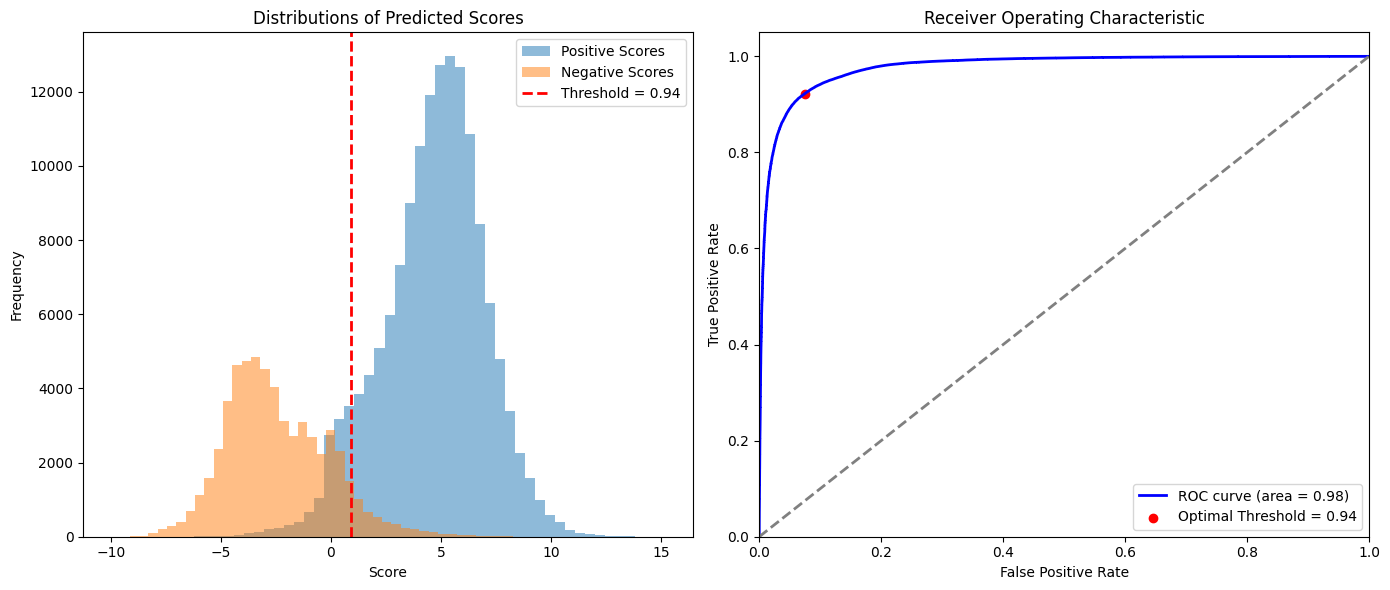

AUC: 0.976684167943341
Optimal Threshold: 0.9354811906814575


In [87]:

# ----------- 5. Definir threashold -------------- 
# Concatenar todos los logits y etiquetas al final del entrenamiento
all_logits_train = np.concatenate(all_logits_train, axis=0)
all_labels_train = np.concatenate(all_labels_train, axis=0)
optimal_threshold = plot_roc_curve(all_labels_train, all_logits_train)
print(f"Optimal Threshold: {optimal_threshold}")
 

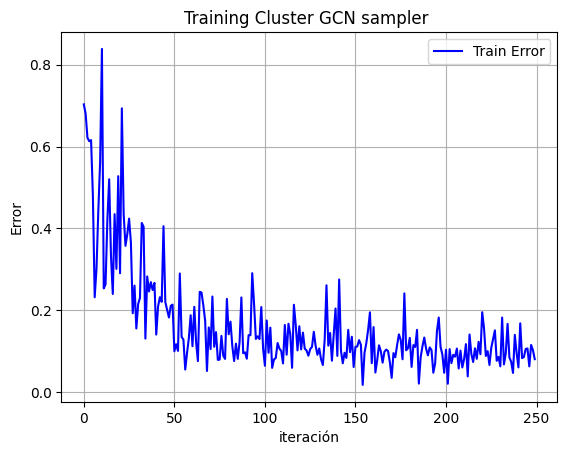

In [88]:
# Crear gráfico del error de entrenamiento
plt.figure()  # Crear una nueva figura
plt.plot([i for i in range(len(train_error))],train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.xlabel('iteración')
plt.ylabel('Error')
plt.title('Training Cluster GCN sampler ')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico de error de entrenamiento



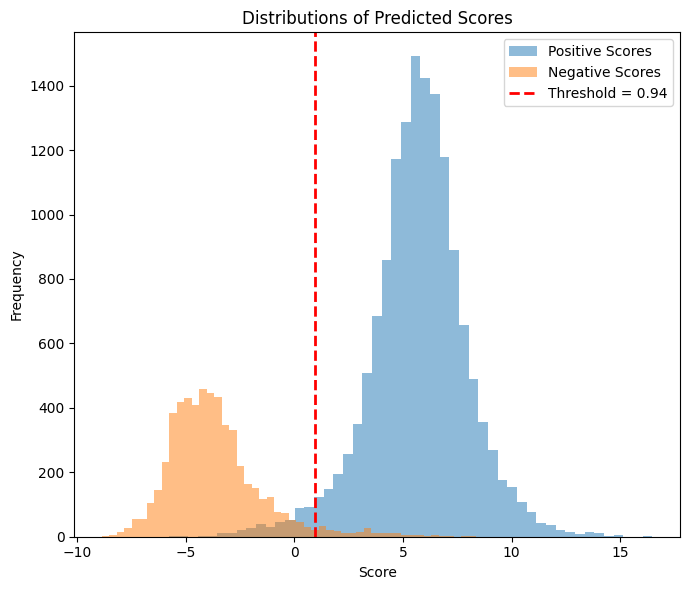

AUC: 0.9918016018344268


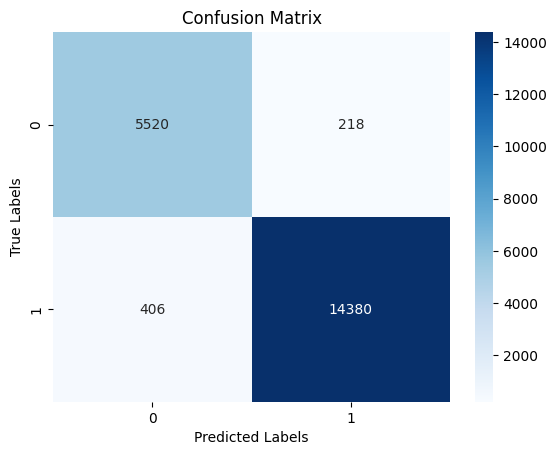

Classification Report:

              precision    recall  f1-score   support

           0     0.9315    0.9620    0.9465      5738
           1     0.9851    0.9725    0.9788     14786

    accuracy                         0.9696     20524
   macro avg     0.9583    0.9673    0.9626     20524
weighted avg     0.9701    0.9696    0.9697     20524



In [89]:
# TEST

plot_roc_curve(val_labels, val_preds, optimal_threshold)
calculate_metrics(test_preds.numpy(),test_labels.numpy() , optimal_threshold)


# Caso 9:
    * Features : PAgeRank
    * Predictor : MLP


In [15]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# NO PERMITE TENER NODOS CON GRADO 0
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


In [16]:
# ----------- 1. Create DGL Graph -------------- #
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.6)

labels = gnn.dgl_graph.edata["Relationship"].float()

Done saving data into cached files.
Cantidad de True: 276453
Cantidad de False: 185436


## Sin Sampling

In [21]:
gnn.dgl_graph


Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'pv': Scheme(shape=(1,), dtype=torch.float32), 'h': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})

In [21]:
# ----------- 2. Run PageRank for Graph -------------- #
N = gnn.dgl_graph.number_of_nodes()
DAMP = 0.85
K = 10


def compute_pagerank(g):
    g.ndata["pv"] = torch.ones(N) / N
    degrees = g.out_degrees(g.nodes()).type(torch.float32)
    for k in range(K):
        g.ndata["pv"] = g.ndata["pv"] / degrees
        g.update_all(
            message_func=fn.copy_u(u="pv", out="m"),
            reduce_func=fn.sum(msg="m", out="pv"),
        )
        g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
    g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
    return g.ndata["pv"]


pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata["h"] = pv  # Inicializa características del nodo

print(gnn.dgl_graph.ndata["pv"])

tensor([[2.7695e-05],
        [3.6634e-05],
        [4.2032e-05],
        ...,
        [6.6453e-06],
        [3.9852e-05],
        [3.4616e-06]])


In epoch 0, train loss: 0.6538940668106079
In epoch 10, train loss: 0.6202468276023865
In epoch 20, train loss: 0.6037826538085938
In epoch 30, train loss: 0.57320636510849
In epoch 40, train loss: 0.5433486700057983
In epoch 50, train loss: 0.46989673376083374
In epoch 60, train loss: 0.3973585069179535
In epoch 70, train loss: 0.37419867515563965
In epoch 80, train loss: 0.33905935287475586
In epoch 90, train loss: 0.3034920394420624


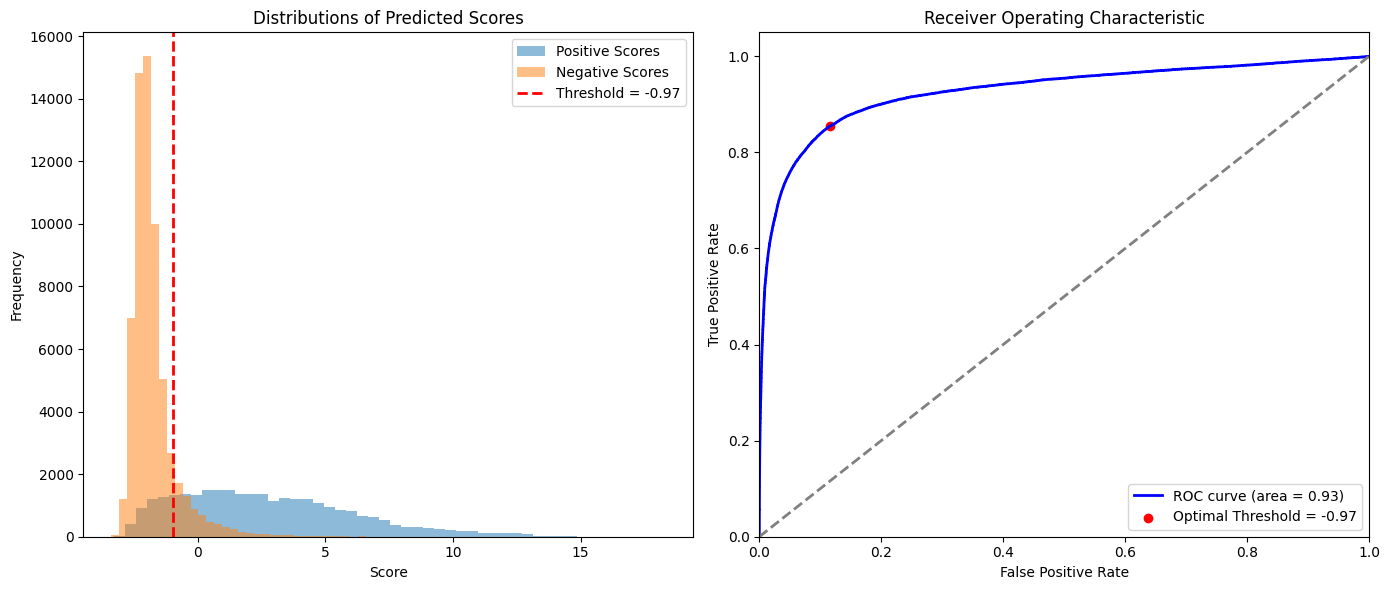

AUC: 0.9271563487953624


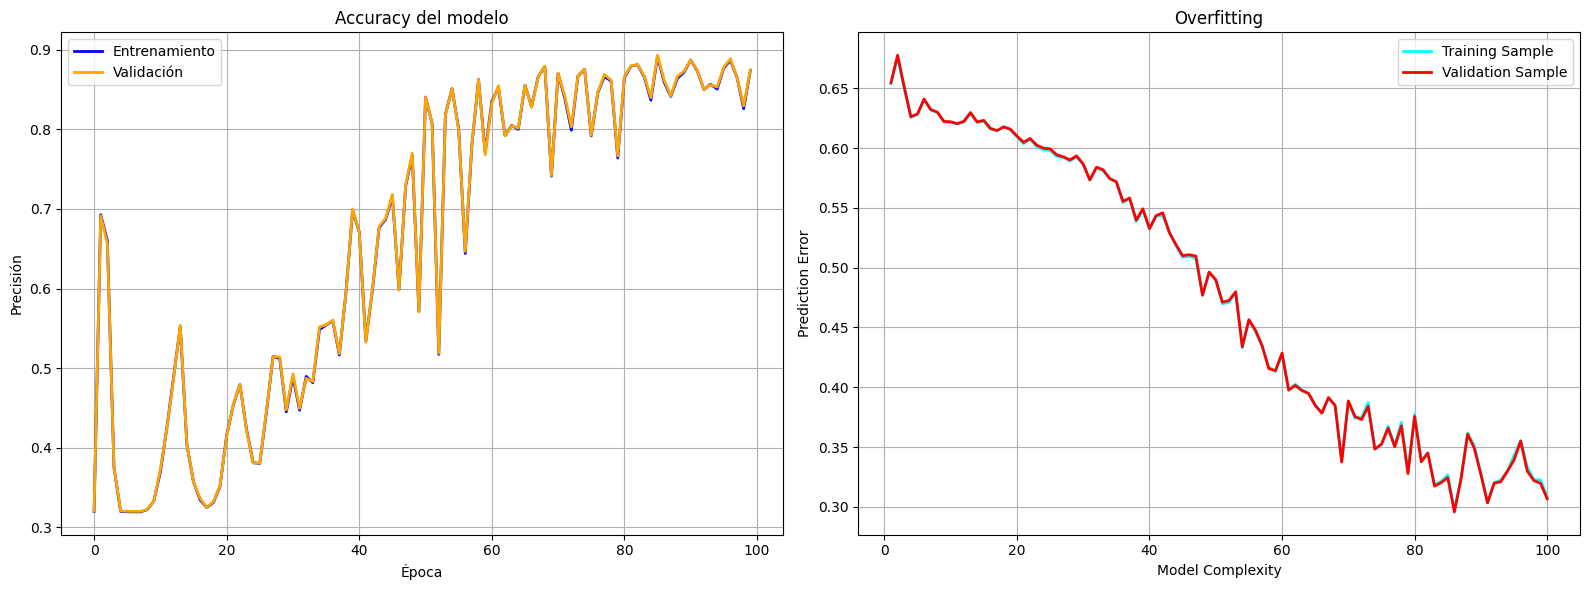

In [24]:
# ----------- 3. Defina MLP predictor and Optimizer -------------- #
# pred = MLPPredictor(1,1)
# optimizer = torch.optim.Adam( pred.parameters(), lr=0.06)
model = GraphSAGE(gnn.dgl_graph.ndata["pv"].shape[1], 100, 25)
pred = MLPPredictor(25,1)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. Traing Loop -------------- #
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []


for epoch in range(100):
    pred.train()
    h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['pv'])
    # logits =  pred(gnn.dgl_graph, gnn.dgl_graph.ndata["pv"])
    logits =  pred(gnn.dgl_graph, h)

    # Calculo pérdida --------------------------------------------------------
    # Calcular la pérdida en el conjunto de entrenamiento --------------------
    train_loss = F.binary_cross_entropy_with_logits(logits[gnn.dgl_graph.edata["train_mask"]], labels[gnn.dgl_graph.edata["train_mask"]])
    train_error.append(train_loss.item())

    # Calcular la pérdida en el conjunto de validación -----------------------
    val_loss = F.binary_cross_entropy_with_logits(logits[gnn.dgl_graph.edata["val_mask"]], labels[gnn.dgl_graph.edata["val_mask"]])
    val_error.append(val_loss.item())

    # Calculo accuracy -------------------------------------------------------
    # Calcular la precisión en el conjunto de entrenamiento
    train_acc = logits[gnn.dgl_graph.edata["train_mask"]]

    # Calcular la precisión en el conjunto de validación
    val_acc = logits[gnn.dgl_graph.edata["val_mask"]] 

    # Guardar los valores de precisión
    acc_train.append(train_acc)
    acc_val.append(val_acc)

    # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
    model_complexity.append(epoch + 1)

    optimizer.zero_grad()
    # train_loss.backward()
    train_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('In epoch {}, train loss: {}'.format(epoch, train_loss))


# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][gnn.dgl_graph.edata["test_mask"]]
predicted_train_scores = logits.detach().numpy()[gnn.dgl_graph.edata["test_mask"]]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)



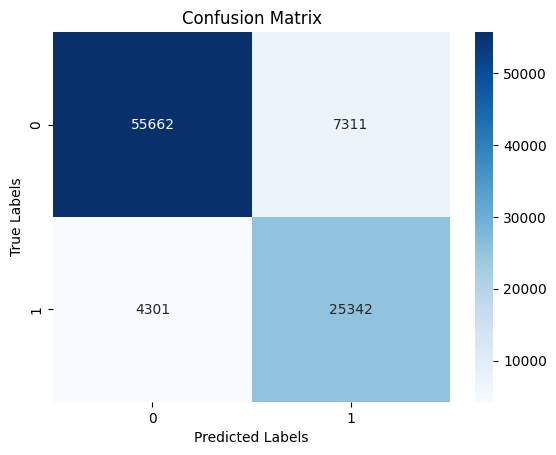

Classification Report:

              precision    recall  f1-score   support

           0     0.9283    0.8839    0.9055     62973
           1     0.7761    0.8549    0.8136     29643

    accuracy                         0.8746     92616
   macro avg     0.8522    0.8694    0.8596     92616
weighted avg     0.8796    0.8746    0.8761     92616



In [25]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


## Con Neighbour sampling

In [26]:
# Grafo
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset_edges(0.5)
gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
node_features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.edata["Relationship"].float()

# gnn.split_dtaset_v2()
train_mask = gnn.train_mask
test_mask = gnn.test_mask

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")


pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata["h"] = pv  # Inicializa características del nodo


Done saving data into cached files.
Cantidad de True: 231290
Cantidad de False: 230599
TRAIN IDX: tensor([ True, False, False,  ..., False,  True, False])
TEST IDX: tensor([False, False,  True,  ..., False, False, False])
TRAIN NIDS: tensor([     0,      5,     12,  ..., 461881, 461885, 461887])
TEST NIDS: tensor([     2,      6,      7,  ..., 461878, 461882, 461884])


In [27]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([2, 2])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([2,2])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)


In [28]:


# # model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = ModelSAGESample(gnn.dgl_graph.ndata["feat"].size(1), 100, 25)
pred = MLPPredictor(25,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam( pred.parameters(), lr=0.05)

# ----------- 4. training -------------------------------- #
acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error_per_epoch = []
train_edges_id = []

# Inicializar listas para guardar logits y labels del entrenamiento
all_logits_train = []
all_labels_train = []

# Inicializar listas para guardar logits y labels de la validacion
all_logits_val = []
all_labels_val = []
# Almacenar la importancia de características por epoch
feature_importances = []
for epoch in range(5):
    model.train()
    val_loss_epoch=0
    num_batches = 0

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
    
            mfgs = [graph for graph in mfgs]
            edge_ids = output_graph.edata[dgl.EID]
            inputs = mfgs[-1].srcdata['pv']

            m = compute_pagerank(output_graph)
            # Hacer que los inputs requieran gradiente
            inputs.requires_grad_(True)
            # Embeddings de nodos
            print(inputs)
            logits =  pred(output_graph, m)
            
            
#             train_edges_id.append(edge_ids)

#             # Usar los IDs de los bordes para obtener las etiquetas reales
#             labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].float()

#             all_logits_train.append(logits.detach().cpu().numpy())
#             all_labels_train.append(labels_batch_output.cpu().numpy())
#             # print("LOGITS",logits,logits.shape)
#             # print("LABEL",mfgs[-1].edata['Relationship'].shape )

#             # Calculo pérdida --------------------------------------------------------
#             train_loss = F.binary_cross_entropy_with_logits(logits, labels_batch_output)
#             train_error.append(train_loss.item())


#             val_loss_epoch += train_loss.item()
#             num_batches += 1
            
#             # backward
#             optimizer.zero_grad()
#             # train_loss.backward()
#             train_loss.backward()

#                         # Capturar los gradientes con respecto a los inputs (características)
#             grad = inputs.grad  # Este es el gradiente de la pérdida con respecto a los inputs
#             feature_importance_batch = grad.abs().mean(dim=0).cpu().numpy()  # Promediar sobre los nodos y las dimensiones de características
#             feature_importances.append(feature_importance_batch)
#             optimizer.step()

#     train_error_per_epoch.append(val_loss_epoch / num_batches)
        
#     # Validación
#     model.eval()
#     val_loss_epoch = 0
#     num_batches = 0
#     with torch.no_grad():
#         with tqdm.tqdm(test_dataloader) as tq:
#             for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
#                 mfgs = [graph for graph in mfgs]
#                 edge_ids = output_graph.edata[dgl.EID]
#                 inputs = mfgs[0].srcdata['feat']
                
                
#                 # Forward para validación
#                 h_val = model(mfgs, inputs)
#                 logits_val = pred(output_graph, h_val)

#                 # Guardar logits de validacion
#                 all_logits_val.append(logits_val.detach().cpu().numpy())

#                 # Obtener las etiuetas reales
#                 labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].float()
#                 all_labels_val.append(labels_batch_output_val.cpu().numpy())
            
#                 # Calcular pérdida de validación
#                 val_loss_batch = F.binary_cross_entropy_with_logits(logits_val, labels_batch_output_val)
#                 val_loss_epoch += val_loss_batch.item()
#                 num_batches += 1

#     # Almacenar el promedio de la pérdida de validación por epoch
#     val_error_per_epoch.append(val_loss_epoch / num_batches)


#     if epoch % 1 == 0:
#         print('In epoch {}, train loss: {},'.format( epoch,train_loss))



# # ----------- 5. Definir threashold -------------- 
# # Concatenar todos los logits y etiquetas al final del entrenamiento
# all_logits_train = np.concatenate(all_logits_train, axis=0)
# all_labels_train = np.concatenate(all_labels_train, axis=0)
# optimal_threshold = plot_roc_curve(all_labels_train, all_logits_train)
# print(f"Optimal Threshold: {optimal_threshold}")
          

# # ----------- 6. plot the loss and accuracy de training-------------- #
# # FIXME: Ess asi por meintras para q no s ecaiga la funcion
# print("Train Error",train_error)
# # acc_train = train_error
# # val_error = train_error
# # acc_val = train_error
# # model_complexity = [i for i in range(len(train_error))]


# # Crear gráfico del error de entrenamiento
# plt.figure()  # Crear una nueva figura
# plt.plot([i for i in range(len(train_error))],train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
# plt.xlabel('Mini-Batch')
# plt.ylabel('Error')
# plt.title('Training Error over Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()  # Mostrar el gráfico de error de entrenamiento


# # ----------- 6. Visualización de la Importancia de Características -------------- #
# # Convertir la lista de importancias en un array para análisis
# # feature_importances = np.array(feature_importances)

# # Calcular la importancia promedio a lo largo de todos los batches y epochs
# # avg_feature_importance = feature_importances.mean(axis=0)

# # plt.figure()
# # plt.bar(range(len(avg_feature_importance)), avg_feature_importance)
# # plt.xlabel('Feature Index')
# # plt.ylabel('Average Importance')
# # plt.title('Average Feature Importance over Training')
# # # plt.show()

  0%|          | 0/232 [00:00<?, ?it/s]/home/vale/.local/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
  0%|          | 0/232 [00:00<?, ?it/s]


DGLError: Expect number of features to match number of nodes (len(u)). Got 74145 and 1380 instead.

# Caso 9:
    * Features : DeepWalk
    * Predictor : MLP

In [5]:
# # Path de donde se guardaran archivos
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEMultiDiGraph/"
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label
type = "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# # 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

print(graph.nx_graph)

MultiDiGraph with 74145 nodes and 923778 edges


In [31]:
data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset_edges(0.6)

emb = DeepWalk(gnn.dgl_graph)
dataloader = DataLoader(torch.arange(gnn.dgl_graph.num_nodes()), batch_size=300,
                        shuffle=True, collate_fn=emb.sample)

optimizer = SparseAdam(emb.parameters(), lr=0.01)

num_epochs = 1

for epoch in range(num_epochs):
    for batch_walk in dataloader:
        # print("[BATCH]",batch_walk )
        loss = emb(batch_walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=923778,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 554281
Cantidad de False: 369497
Training edges: 554281
Validation edges: 184232
Test edges: 185265


In [32]:
h = emb.node_embed.weight.detach()
print("SHAPE",h.shape)
print("EMBEDDINGS",h)

SHAPE torch.Size([74145, 128])
EMBEDDINGS tensor([[-0.1110, -0.1046,  0.1418,  ..., -0.0324, -0.1556, -0.1033],
        [-0.0991, -0.0820,  0.0520,  ...,  0.1868, -0.1713, -0.0744],
        [-0.1026, -0.0204,  0.0294,  ...,  0.1769, -0.1213, -0.0804],
        ...,
        [-0.0936, -0.0939,  0.0574,  ..., -0.0411, -0.0976, -0.0919],
        [-0.0946, -0.1161,  0.0598,  ..., -0.0151, -0.1091, -0.1117],
        [-0.1162, -0.1062,  0.1076,  ..., -0.1049, -0.1193, -0.1160]])


In [25]:

gnn.dgl_graph.ndata['h'] = h

In [26]:
# Al ser MultiDiGraph tenemos
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1} #cambiar a esto para que sea clasificacióń binaria


edata = gnn.dgl_graph.edata["Relationship"]
# Reemplazar los valores 2 por 1
edata[edata == 2] = 1
gnn.dgl_graph.edata["Relationship"]

# Actualizar la edata en el grafo con los nuevos valores
gnn.dgl_graph.edata["Relationship"] = edata

In [27]:
print(gnn.dgl_graph.edata["Relationship"])
print(gnn.dgl_graph.ndata["h"])
print(gnn.dgl_graph.ndata["h"].shape)

tensor([0, 0, 0,  ..., 1, 1, 1])
tensor([[-0.0541, -0.0022,  0.1283,  ...,  0.0720, -0.1066, -0.1013],
        [-0.1901,  0.0133,  0.1456,  ...,  0.1779, -0.0989, -0.0503],
        [-0.2788,  0.0112,  0.1553,  ...,  0.4571, -0.1823, -0.0017],
        ...,
        [-0.0368,  0.1021,  0.1252,  ...,  0.1107, -0.1114, -0.0893],
        [-0.1584,  0.0362,  0.0934,  ...,  0.3378, -0.1441,  0.0194],
        [ 0.0011,  0.0766,  0.0762,  ...,  0.0712, -0.0859, -0.0609]])
torch.Size([74145, 128])


In [28]:
train_mask = gnn.dgl_graph.edata["train_mask"]
test_mask = gnn.dgl_graph.edata["test_mask"]
labels = gnn.dgl_graph.edata["Relationship"].float()
pred = MLPPredictorEmbeddings(gnn.dgl_graph.ndata["h"].shape[1],1)
                        
# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam( pred.parameters(), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(50):

    logits = pred(gnn.dgl_graph,gnn.dgl_graph.ndata["h"]) 
    train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
    train_error.append(train_loss.item())
    
    val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
    val_error.append(val_loss.item())

    # Calculo accuracy -------------------------------------------------------
    # Calcular la precisión en el conjunto de entrenamiento
    train_acc = logits[train_mask]

    # Calcular la precisión en el conjunto de validación
    val_acc = logits[gnn.val_mask] 

    # Guardar los valores de precisión
    acc_train.append(train_acc)
    acc_val.append(val_acc)

    # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
    model_complexity.append(epoch + 1)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('In epoch {}, train loss: {}'.format(epoch, train_loss))



In epoch 0, train loss: 0.688713550567627
In epoch 10, train loss: 0.24913956224918365
In epoch 20, train loss: 0.21667298674583435
In epoch 30, train loss: 0.18810109794139862
In epoch 40, train loss: 0.17043155431747437


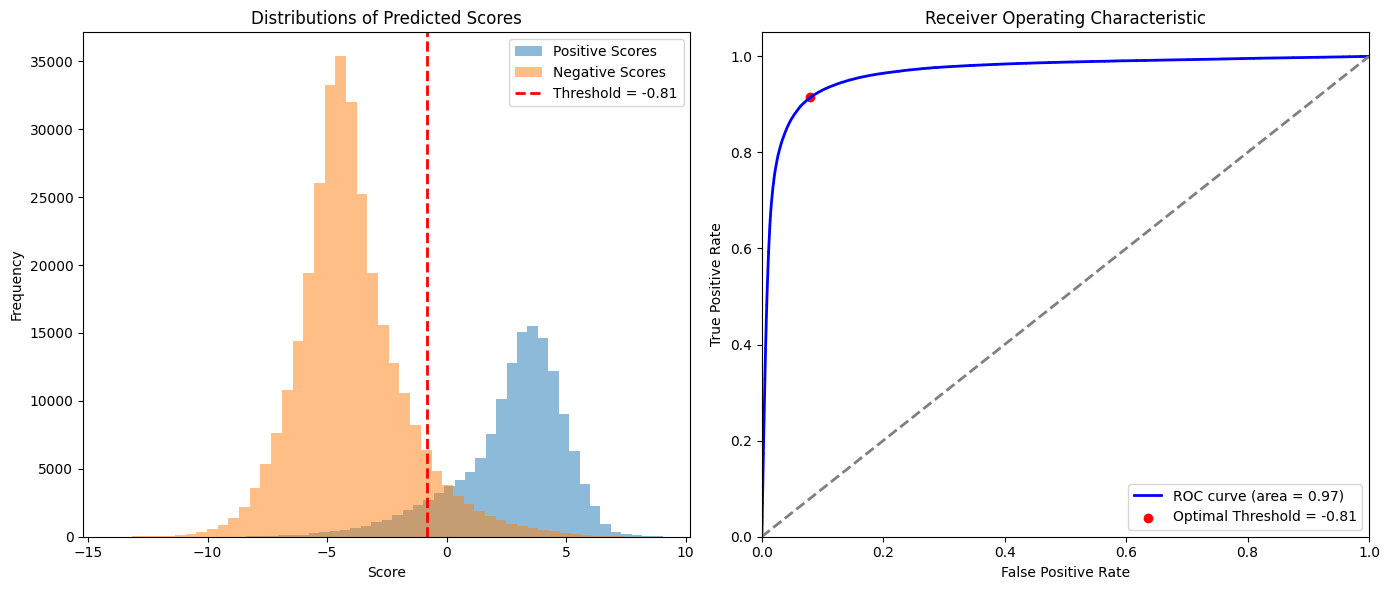

AUC: 0.9657286289985192


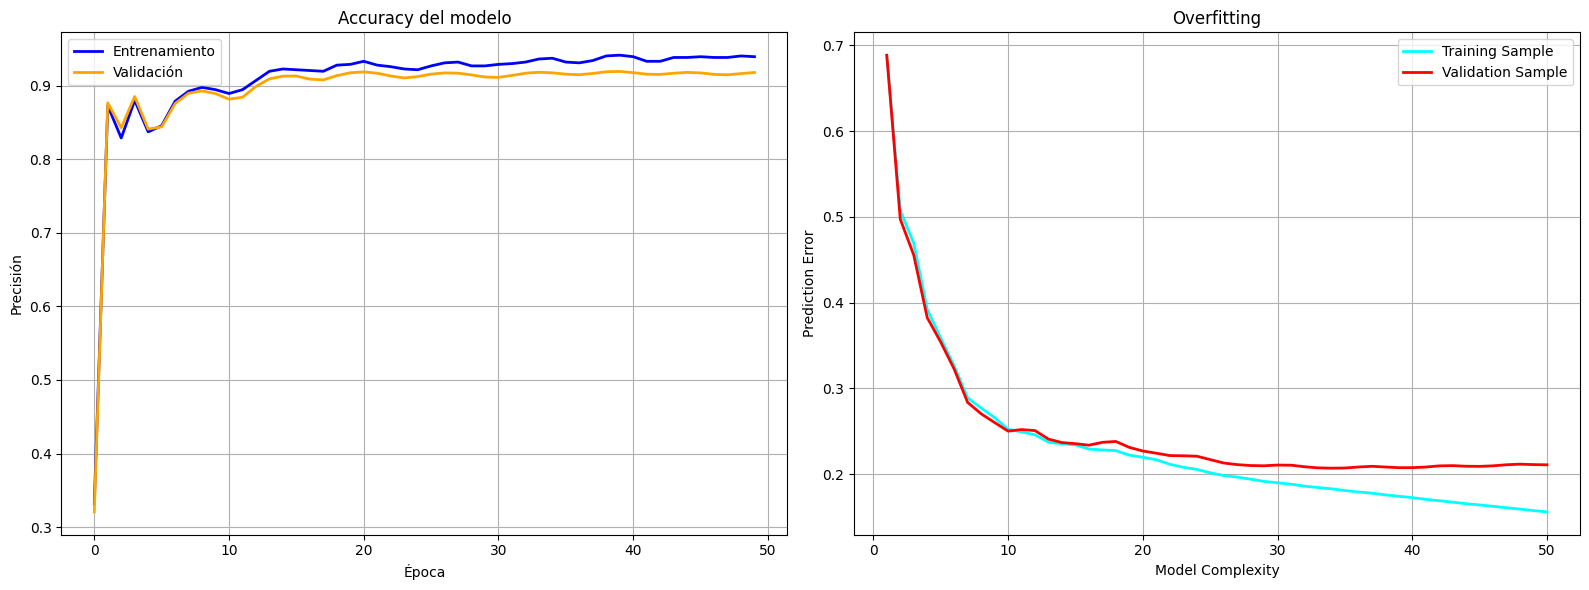

In [29]:
# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


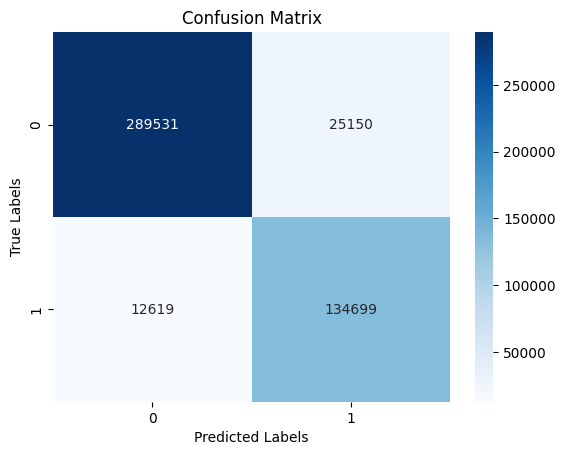

Classification Report:

              precision    recall  f1-score   support

           0     0.9582    0.9201    0.9388    314681
           1     0.8427    0.9143    0.8770    147318

    accuracy                         0.9182    461999
   macro avg     0.9004    0.9172    0.9079    461999
weighted avg     0.9214    0.9182    0.9191    461999



In [30]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)



# CASO: X
Aprender embeddings/representaciones de los nodos desde 0.

In [3]:
# Creo Grafo
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# NO PERMITE TENER NODOS CON GRADO 0
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


In [15]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset_edges(0.6)
train_mask = gnn.dgl_graph.edata["train_mask"]
test_mask = gnn.dgl_graph.edata["test_mask"]

import torch.nn as nn
emb = nn.Embedding(gnn.dgl_graph.num_nodes(), 100)
gnn.dgl_graph.ndata['h'] = emb.weight
model = GraphSAGE(100, 150, 50)
pred = MLPPredictor(50,1)

optimizer = torch.optim.Adam(itertools.chain(emb.parameters(), model.parameters(), pred.parameters()), lr=0.001)

labels = gnn.dgl_graph.edata["Relationship"].float()

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for epoch in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['h'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(epoch + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))



Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Cantidad de True: 276773
Cantidad de False: 185116
Training edges: 276773
Validation edges: 93043
Test edges: 92073
In epoch 0, train loss: 0.6773274540901184, val loss: 0.6764032244682312
In epoch 10, train loss: 0.5465342998504639, val loss: 0.5470790266990662
In epoch 20, train loss: 0.4472990930080414, val loss: 0.4487597942352295
In epoch 30, train loss: 0.3586054742336273, val loss: 0.360866904258728
In epoch 40, train loss: 0.3076976537704468, val loss: 0.31440240144729614
In epoch 50, train loss: 0.2738799452781677, val loss: 0.2851794958114624
In epoch 60, train loss: 0.23813265562057495, val loss: 0.24605929851531982
In epoch 70, train loss: 0.22271353006362915, val loss: 0.23336462676525116
In epoch 80, train loss: 0.20581784844398499, val loss: 0.21887788

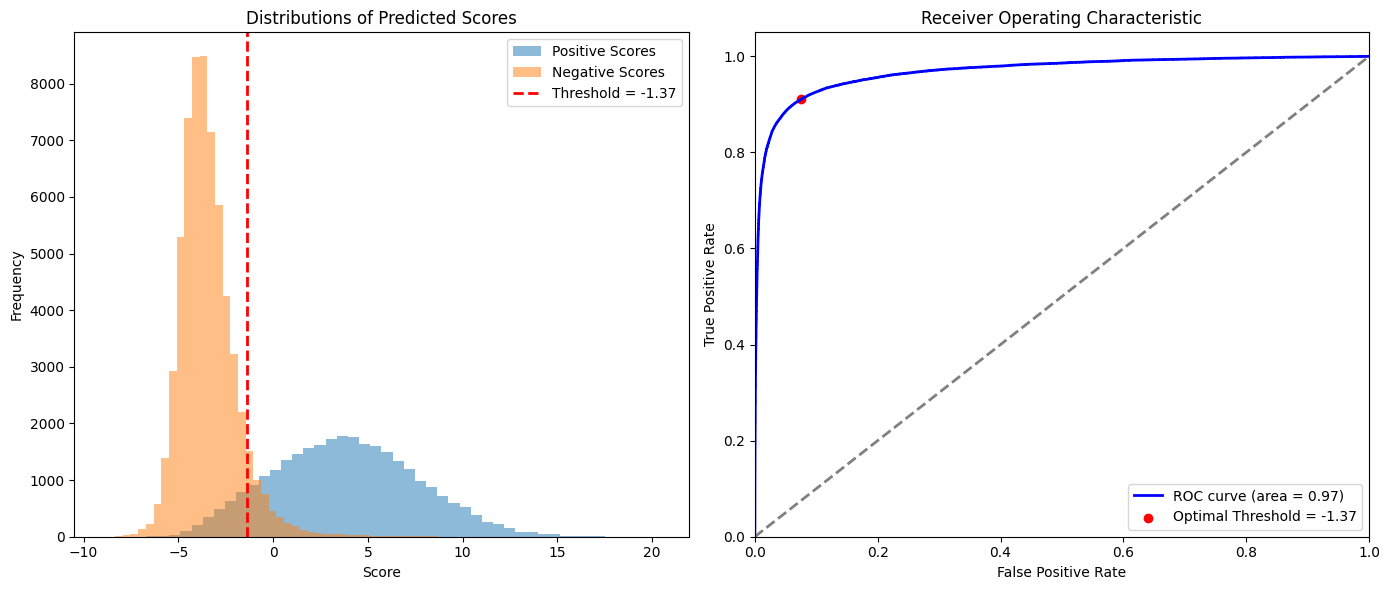

AUC: 0.9687262617532633


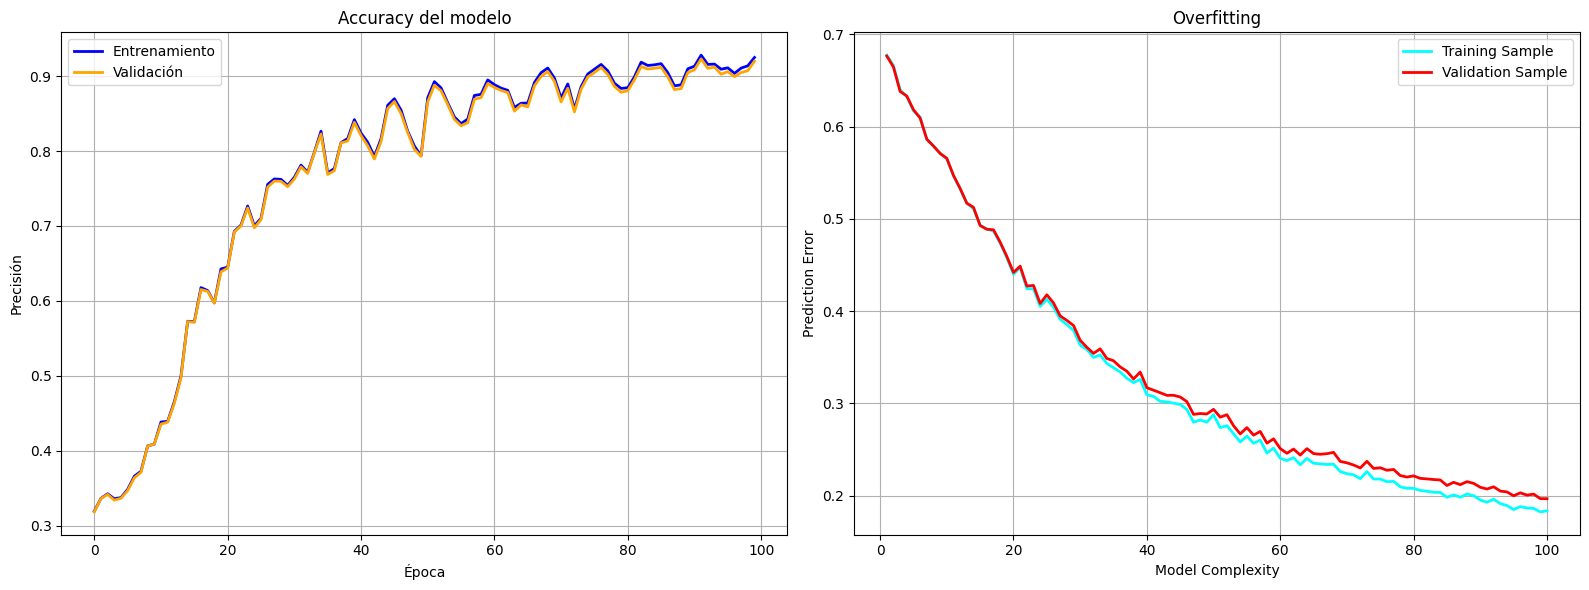

In [18]:
# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)

# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


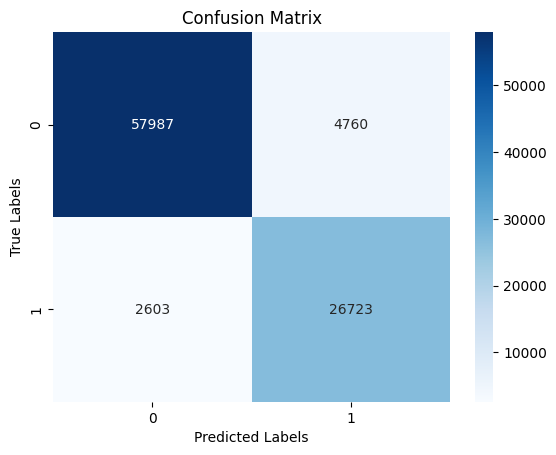

Classification Report:

              precision    recall  f1-score   support

           0     0.9570    0.9241    0.9403     62747
           1     0.8488    0.9112    0.8789     29326

    accuracy                         0.9200     92073
   macro avg     0.9029    0.9177    0.9096     92073
weighted avg     0.9226    0.9200    0.9207     92073



In [19]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


# CASO: BGP2VEC

## Crear los embedding bgp2vec

In [7]:
# Embeddings ASN BGP2VEC
import os
from bgp2vec.bgp2vec import BGP2VEC
from gensim.models import Word2Vec

oix_path = os.getcwd()+  "/datasets/RouteViews/Download/oix-full-snapshot-2022-06-30-2000.bz2"
test_limit = 2000000 #cantidad paths/horaciones
mode = None# 'test' # par limitar cantidad de paths/oraciones
epochs = 1
debug = True
model_path = os.getcwd()+"/bgp2vec/bgp2vec.word2vec"

# Crea embeddings de ASN con  BGP2VEC y lo guarda en "/bgp2vec/bgp2vec.word2vec"
bgp2vec = BGP2VEC(model_path = model_path ,oix_path=oix_path,rewrite=True, test_limit= test_limit, mode = mode, epochs = epochs)

print("[MODELO]",bgp2vec.model)
print("[TOTAL ASN]",bgp2vec.model.corpus_total_words)

# index = bgp2vec.model.wv['701']
# print(f"[INDEX ASN {'701'}] {index}")
# print(f"[INDEX ASN {'701'}] {bgp2vec.asn2vec('701')}")
# print("IMPOT ")
# MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"
# print(f"PATH {MODELS_PATH}")
# BGP2Vec_model = Word2Vec.load(MODELS_PATH)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vale/Desktop/GIT/TESIS/datasets/RouteViews/Download/oix-full-snapshot-2022-06-30-2000.bz2'

### Importar Embeddings

In [4]:
MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"

# Importar embeddings ASN
BGP2Vec_model = Word2Vec.load(MODELS_PATH)

emdeddings = BGP2Vec_model.wv.vectors
total_ASNs, embedding_vecor_length = emdeddings.shape

print(f"[TOTAL ASN]: {total_ASNs}" )

print(f"[EMBEDDINGS LEN]: {embedding_vecor_length}")
print(f"[EMBEDDINGS] {emdeddings}")




[TOTAL ASN]: 74238
[EMBEDDINGS LEN]: 32
[EMBEDDINGS] [[-2.1472703e-01  6.3407493e-01  2.6631510e-01 ... -6.7314707e-02
   5.2685094e-01  9.1462356e-01]
 [-1.3031145e+00  8.3815610e-01  5.3771269e-01 ... -2.9695952e-01
  -2.3368393e-01  4.5706276e-02]
 [-7.9452795e-01  5.5671680e-01 -6.1896056e-01 ... -2.6427367e-01
  -2.6843885e-01  1.3504244e+00]
 ...
 [-1.1700593e-02 -1.3378471e-02  5.4460280e-03 ...  2.8491393e-04
  -1.2418743e-02  2.4866499e-03]
 [ 2.3998376e-02  1.9970149e-02 -2.5604732e-02 ...  1.7985072e-02
   5.2202269e-03 -3.0413084e-02]
 [ 7.9072835e-03 -3.8274422e-02 -4.1166581e-02 ...  3.5102013e-02
   9.1040730e-03 -3.5600732e-03]]


### Dataser AS Relationships

In [ ]:
from utils import edges_and_relationships_from_dgl_graph


In [6]:
# Datset TOR
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
gnn = GNN(debug = True)

gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
#FIXME: probar
gnn.dgl_graph.ndata['h'] = emdeddings


list_edges, labels = edges_and_relationships_from_dgl_graph(gnn.dgl_graph)
emb = nn.Embedding(gnn.dgl_graph.num_nodes(), 100)
print("[EDGES]\n",list_edges)
print("[LABELS]", labels)

Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})


DGLError: Expect number of features to match number of nodes (len(u)). Got 74238 and 74145 instead.

In [28]:
# Split dataset
TEST_SIZE = 0.2
# Generat indices para dataset
indices = np.arange(len(list_edges))

x_training, x_test, indices_training, indices_test = train_test_split(list_edges, indices, test_size=TEST_SIZE) 
y_training = labels[indices_training]
y_test = labels[indices_test]

print("[TRAINING]" ,x_training.shape, y_training.shape)
print("[TEST]",x_test.shape, y_test.shape)
print("[TRAINIG %]",1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print("[COUNTER TRAINING]",training_c)
print("[COUNTER TEST]",test_c)

[TRAINING] (369511, 2) (369511,)
[TEST] (92378, 2) (92378,)
[TRAINIG %] 0.7999995669955335
[COUNTER TRAINING] Counter({0: 251276, 1: 118235})
[COUNTER TEST] Counter({0: 62913, 1: 29465})


In [1]:
# Datset TOR
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0

list_edges, labels = edges_and_relationships_from_dgl_graph(gnn.dgl_graph)



NameError: name 'GNN' is not defined